# Analysis of German Speech from SpeechRecognition using various ASR.

## Overview, Libraries and import Statements

### Overview

Following text was read and recorded in different format by speakers and the audio was converted appropriate to wav and mp3 format before processing:

Einst stritten sich Nordwind und Sonne, wer von ihnen beiden wohl der Stärkere wäre, als ein Wanderer, der in einen warmen Mantel gehüllt war, des Weges daherkam. Sie wurden einig, dass derjenige für den Stärkeren gelten sollte, der den Wanderer zwingen würde, seinen Mantel abzunehmen. Der Nordwind blies mit aller Macht, aber je mehr er blies, desto fester hüllte sich der Wanderer in seinen Mantel ein. Endlich gab der Nordwind den Kampf auf. Nun erwärmte die Sonne die Luft mit ihren freundlichen Strahlen, und schon nach wenigen Augenblicken zog der Wanderer seinen Mantel aus. Da musste der Nordwind zugeben, dass die Sonne von ihnen beiden der Stärkere war. 

### Libraries installation

In [2]:
%%capture --no-display
!pip install SpeechRecognition
!pip install setuptools
!pip install pyaudio
!pip install pandas
!pip3 install pocketsphinx
!pip install requests
!pip install vosk
!pip install seaborn
!pip install praat-parselmouth

### Import statements

In [293]:
import speech_recognition as sr
import os
import requests
import json
import pyaudio
import wave
import time
from collections import Counter
from vosk import Model, KaldiRecognizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
import math
import numpy as np
import matplotlib.patches as patches
from scipy import stats
import ast
import os
from pydub import AudioSegment
import librosa
import librosa.display
import matplotlib.gridspec as gridspec
import parselmouth

## PART: A: Speech Recognition

### Function definitions:

#### Function to perform recognition using AssemblyAI.

In [2]:

def upload_audio(filename,UPLOAD_URL,API_key):
    headers = {'authorization': API_key}
    with open(filename, 'rb') as f:
        response = requests.post(UPLOAD_URL, headers=headers, files={'file': f})
    response.raise_for_status()
    return response.json()['upload_url']

def transcribe_audio(upload_url,TRANSCRIPT_URL,API_key):
    headers = {'authorization': API_key, 'content-type': 'application/json'}
    data = {'audio_url': upload_url, 'language_code': 'de'}
    response = requests.post(TRANSCRIPT_URL, headers=headers, json=data)
    response.raise_for_status()
    return response.json()['id']

def check_transcription_status(transcript_id,TRANSCRIPT_URL,API_key):
    headers = {'authorization': API_key}
    response = requests.get(f'{TRANSCRIPT_URL}/{transcript_id}', headers=headers)
    response.raise_for_status()
    return response.json()

def assembly_ai(audio_file_mp3,API_key):
    UPLOAD_URL = 'https://api.assemblyai.com/v2/upload'
    TRANSCRIPT_URL = 'https://api.assemblyai.com/v2/transcript'
    audio_file = audio_file_mp3
    print("Processing audio file...",audio_file)

    # Upload audio file
    upload_url = upload_audio(audio_file,UPLOAD_URL,API_key)
    
    # Request transcription
    transcript_id = transcribe_audio(upload_url,TRANSCRIPT_URL,API_key)

    # Wait for transcription to complete
    print("Waiting for transcription...")
    
    start_time = time.perf_counter()
    while True:
        result = check_transcription_status(transcript_id,TRANSCRIPT_URL,API_key)
        end_time = time.perf_counter()
        if result['status'] == 'completed':
            print("Transcription completed.")
            #print(f"Recognized text: {result['text']}") #used for debugging
            break
        elif result['status'] == 'failed':
            print("Transcription failed.")
            return ("TIME OUT !")
            break
        else:
            time.sleep(5)  # Wait before checking again
            if((end_time - start_time) > 60):
                print('TIME OUT !')
                return "TIME OUT !"
                break

    return result['text']

#### Function to perform recognition using VOSK.
Requirements: WAV file must be mono PCM with 16kHz sample rate and 16-bit depth.

In [12]:
def vosk(audio_file_wav, model_path):
    # Check if the model directory exists
    if not os.path.exists(model_path):
        print("Please download the model from https://alphacephei.com/vosk/models and unpack as 'vosk-model-small-de-0.15' in the specified folder.")
        exit()

    # Load the model
    model = Model(model_path)

    # Open the WAV file
    wf = wave.open(audio_file_wav, 'rb')

    # Initialize recognizer
    recognizer = KaldiRecognizer(model, wf.getframerate())
    print("Processing audio file...", audio_file_wav)

    # Collect final results
    results = []

    while True:
        data = wf.readframes(4096)  # Buffer size, tested with different sizes found 4096 appropriate.
        if len(data) == 0:
            break

        # Process the audio and collect results
        if recognizer.AcceptWaveform(data):
            result = json.loads(recognizer.Result())
            results.append(result["text"])  # Append the recognized text
        else:
            # Optional: Collect partial results (for debugging)
            partial = recognizer.PartialResult()
            #print("Partial result for {}: {}".format(audio_file_wav, partial))

    # Final result after the audio has been fully processed
    final_result = recognizer.FinalResult()
    if final_result:  # To Ensure to capture final result even if small
        results.append(json.loads(final_result)["text"])

    wf.close()

    # Combine all results into the final text
    final_text = " ".join(results)

    if not final_text:
        print("No text recognized for", audio_file_wav)
    return final_text


#### Function to perform recognition using Google Web Speech along with calling asssembly.ai and vosk upon requirements.

In [10]:
'''
Requires audio_file as wav, speech to text engine name, and API key.
Returns the results in text form. 
'''
def analyze_audio(audio_file,engine, vosk_model_path, API_key = None):
    result = ''

    # Try recognizing the audio for various models
    try:
        if(engine == 'Google_Web_Speech_API'):
            print("\nRecognizing using Google_Web_Speech_API....")
            # Initialize the recognizer
            recognizer = sr.Recognizer()

            # Load the audio file
            audio_file = sr.AudioFile(audio_file)

            with audio_file as source:
                # Adjust for ambient noise
                recognizer.adjust_for_ambient_noise(source)
                
                # Record the audio
                audio_data = recognizer.record(source)

            print("Processing audio file...",audio_file)
            result = recognizer.recognize_google(audio_data, language='de-DE')

        elif(engine == 'VOSK'):
            print("\nRecognizing using Vosk....")
            result = vosk(audio_file, vosk_model_path)
            
        elif(engine == 'AssemblyAI'):
            print("\nRecognizing using AssemblyAI....")
            if(API_key is None):
                print("API REQUIRED !")
                return "ERROR:API NOT FOUND !"
            for filename in audio_file:
                if filename.lower().endswith('.wav'):
                    print("Change to MP3 !")
                    return "ERROR: WAV NOT SUPPORTED USE MP3 !"
            result=assembly_ai(audio_file,API_key)

        else:
            result = 'Non-implemented engine:'+engine
        print("Recognized Text:", result)

    except sr.UnknownValueError:
        # If speech is unintelligible
        print("Speech Recognition could not understand the audio")
        result = 'UnknownValueError'
    except sr.RequestError:
    # If the API is unreachable or any other network issues
        print("Could not request results from Speech Recognition service")
        result = 'RequestError'
        
    return result

### Main Implementation for speech recognition

In [13]:
# Path to the German model only used for VOSK
vosk_model_path = r"D:\_workspace\_vscode\Universität-Trier\Advance_Computation\1\Phenotics_Analysis\data\vosk-model-small-de-0.15"

# Folder path
folder_path = "data/processed_audio\\"
# List all .wav files
wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
print("Number of .wav recordings : ",len(wav_files))

# List all .mp3 files
mp3_files = [f for f in os.listdir(folder_path) if f.endswith('.mp3')]
print("Number of .mp3 recordings : ",len(mp3_files))

#Check if every wav has corresponding mp3 for Assembly.AI
if([os.path.splitext(f)[0] for f in wav_files]!=[os.path.splitext(f)[0] for f in mp3_files]):
    print("WAV AND MP§ FILES ARE NOT EQUAL IN THE FOLDER !")
    exit
else:
    files_no_ext = [os.path.splitext(f)[0] for f in wav_files]

# Initialize empty DataFrame
columns = ['FileName', 'text']

#Load engines and their API Keys (API key is required for Assembly.AI)
engines_API = pd.read_csv('data/00_PRIVATE_API_info.csv')

# Create columns for each engine in engines_API
for engine in engines_API['engine']:
    columns.append(engine)

df = pd.DataFrame(columns=columns)

# Create a dictionary to hold results for each file
results = {file: {engine: '' for engine in engines_API['engine']} for file in files_no_ext}

for file in files_no_ext:
    for index, row in engines_API.iterrows():    
        engine = row['engine']
        api_key = row['API_key']
        print("======== Analyzing ==============")
        if(engine!="AssemblyAI"):
            print(file+".wav")
            text = analyze_audio(folder_path + file + ".wav", engine, vosk_model_path, api_key)
        else:
            print(file+".mp3")
            text = analyze_audio(folder_path + file + ".mp3", engine, None, api_key)
        results[file][engine] = text

print("======== saving results ==============")
# Convert results dictionary to DataFrame
df = pd.DataFrame.from_dict(results, orient='index').reset_index()
df.rename(columns={'index': 'FileName'}, inplace=True)

# Sort DataFrame by 'FileName'
df = df.sort_values(by='FileName').reset_index(drop=True)


# Path for the CSV file
csv_file_path = 'output_audio_recognition.csv'
# Write the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False,encoding='utf-8-sig')
print("DataFrame written to",csv_file_path)

Number of .wav recordings :  1
Number of .mp3 recordings :  1
======== Analyzing ==============
13.wav

Recognizing using Vosk....
Processing audio file... data/processed_audio\13.wav
Recognized Text: einst stritten sich nordwind und sonne wer von ihnen beiden wohl der stärkere wäre als ein wanderer der an einem warmen mantel gehüllt war des weges daherkam sie wurden einig daß derjenige für den stärkeren gelten sollte der dem wanderer zwingen würde seinem mantel abzunehmen der nordwind blies mit aller macht aber je mehr er blies desto fester hüllte sich der wanderer in seinen mantel ein endlich gab der nordwind den kampf auf nun erwärmte die sonne die luft mit ihren freundlichen strahlen und schon nach wenigen auge blicken zog der wanderer seinen mantel aus da musste der nordwind zugeben dass die sonne von in beiden der stärkere war
======== Analyzing ==============
13.wav

Recognizing using Google_Web_Speech_API....
Processing audio file... <speech_recognition.AudioFile object at 0x00

## Analysis of Transcriptions 

### Perform manual operations on the 'output_audio_analysis.csv'

Performed manual text alignment on the 'output_audio_analysis.csv'. the SAMPA phonotics for the German words were found from: [unalengua.com](http://tom.brondsted.dk)](http://tom.brondsted.dk/text2phoneme/)

### Importing the required Transcribed files

In [27]:
# Load Phenotic (SAMPA) data for all models and filtered out P11 because of background noise.
AAI_p_df = pd.read_csv('data/00_AAI_p_analysis.csv', delimiter=',', encoding='utf-8-sig', usecols=lambda column: column != 'P11')
GWS_p_df = pd.read_csv('data/00_GWS_p_analysis.csv', delimiter=',', encoding='utf-8-sig', usecols=lambda column: column != 'P11')
VOSK_p_df = pd.read_csv('data/00_VOSK_p_analysis.csv', delimiter=',', encoding='utf-8-sig', usecols=lambda column: column != 'P11')

# Display the first few rows of the DataFrame
print(AAI_p_df.head(2))
print(GWS_p_df.head(2))
print(VOSK_p_df.head(2))

        original          P01            P02              P03       P04  \
0       aI n s t     aI n s t       aI n s t             aI n  aI n s t   
1  S t R I t @ n  S R I t @ n  S t E l t @ n  S t R I n d @ n         -   

              P05             P06           P07            P08  \
0            aI n        aI n s t        aI n s         aI n s   
1  S t R e: t @ n  S t R e: t @ n  t R e: t @ n  S t R I t @ n   

                  P09             P10           P12            P13  
0               a l s        aI n s t        aI n s       aI n s t  
1  E 6^ s t R I t @ n  S t R e: t @ n  ts v I S @ n  S t R I t @ n  
        original           P01           P02            P03     P04  \
0       aI n s t  d Y 6^ f @ n        aI n s              -  aI n s   
1  S t R I t @ n             -  S t e: t I n  S t U n d @ n       -   

              P05              P06               P07             P08    P09  \
0      m aI n s t  z y: d @ n z e:  aI n S t E k @ n          aI n s  a l s

### Perform analysis and create list for phenotics which are correct, wrong, extra_spoken and count of empty_cells

In [28]:
#Step-1

# Function to perform comparison
def compare_phonetics(original, comparison):
    
    # Convert values to strings to avoid AttributeError
    original = str(original) if pd.notna(original) else ''
    comparison = str(comparison) if pd.notna(comparison) else ''

    # Handle cases where the comparison cell is '-'
    if comparison.strip() == '-':
        return '', '', '', 1  # Return empty strings and count 1 empty cell
    
    # Split the original and comparison strings by space
    original_list = original.split()
    comparison_list = comparison.split()

    # Count the occurrences of each item in the lists
    original_count = Counter(original_list)
    comparison_count = Counter(comparison_list)

    correct = []
    wrong = []
    extra_spoken_p = []

    # Check for correct items
    for item in original_count:
        if item in comparison_count:
            # Add the minimum count of the item in both lists to correct
            count = min(original_count[item], comparison_count[item])
            correct.extend([item] *  count)

            # Remove the item from comparison_count by subtracting
            comparison_count[item] -=  count
            if comparison_count[item] <= 0:
                del comparison_count[item]

    # Calculate wrong items
    wrong_count = original_count - Counter(correct)  # Subtract correct counts from original
    wrong = list(wrong_count.elements())  # Flatten the wrong counts into a list

    # Add items from comparison_list that were not in original_list
    comparison_wrong_extra = [item for item in comparison_list if item not in correct]
    extra_spoken_p.extend(comparison_wrong_extra)

    # Filter out unwanted values ('nan', '', None) from extra_spoken_p
    extra_spoken_p = [item for item in extra_spoken_p if item.lower() != 'nan' and item != '' and item is not None]

    # Return correct and wrong lists, empty if empty
    return correct if correct else '', wrong if wrong else '', extra_spoken_p if extra_spoken_p else '', 0


def perform_Step1(dfx,libx):

    # Load the data into a pandas DataFrame
    df = dfx.astype(str)
    lib = libx

    # Initialize a list to store results
    results = []

    # Iterate over each column in the DataFrame (excluding 'original')
    for col in df.columns:
        if col != 'original':
            # Apply the comparison function for each row
            for _, row in df.iterrows():
                original = row['original']
                comparison = row[col]
                correct, wrong, extra_spoken_p, empty_count   = compare_phonetics(original, comparison)

                # Create a dictionary for the result
                result = {
                    'speaker_id': col, # The column name is used to identify which speaker (P01, P02, etc.)
                    'Library': lib,
                    'correct_p': correct,
                    'wrong_p': wrong,
                    'extra_spoken_p':extra_spoken_p,
                    'empty_cells': empty_count
                }

                # Append the result to the list
                results.append(result)

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # return the results
    return results_df


In [29]:
#Perform analysis for all three libraries
libx = ['Assembly.AI', 'Google_Web_Speech', 'VOSK']
dfx = [AAI_p_df, GWS_p_df, VOSK_p_df]

if (len(dfx) == len(libx)):
    for i in range(len(libx)):
        results_df = perform_Step1(dfx[i], libx[i])
        # Append results to CSV file
        results_df.to_csv('data/01_results_phonetic_list.csv', mode='a', header=not os.path.isfile('data/01_results_phonetic_list.csv'), index=False, encoding='utf-8-sig')

In [30]:
results_df

speaker_id Library                  correct_p     wrong_p extra_spoken_p  \
0           P01    VOSK                 [aI, n, s]         [t]                  
1           P01    VOSK         [S, t, R, I, @, n]         [t]                  
2           P01    VOSK                  [z, I, C]                              
3           P01    VOSK        [n, n, O, 6^, t, v]     [t, i:]      [E, d, @]   
4           P01    VOSK                  [U, n, t]                              
...         ...     ...                        ...         ...            ...   
1291        P13    VOSK                        [n]  [i:, n, @]            [I]   
1292        P13    VOSK           [b, aI, d, @, n]                              
1293        P13    VOSK                [d, e:, 6^]                              
1294        P13    VOSK  [S, t, E, 6^, k, @, @, R]                              
1295        P13    VOSK                [v, a:, 6^]                              

      empty_cells  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
1291            0  
1292            0  
1293            0  
1294            0  
1295            0  

[1296 rows x 6 columns]

In [31]:
# Load the CSV file
file_to_analyze = 'data/01_results_phonetic_list.csv'
df = pd.read_csv(file_to_analyze, delimiter=',', encoding='utf-8-sig')

# Define lists for phoneme categories
vowel_realisation_r = ['6','i:6','I6','y:6','Y6','e:6','E6','E:6','2:6','96','a:6','a6','u:6','U6','o:6','O6']
free_diphthongs = ['aI', 'aU' ,'OY']
glottal_stop = ['?']
phonemic_affricates = ['pf','ts','tS','dZ']
checked_vowels = ['I', 'E', 'a', 'O', 'U', 'Y', '9:']
plosives =  ['p', 'b', 't', 'd', 'k', 'g']
fricatives= ['f','v','s','z','S','Z','C','j','x','h']
nasals_liquids = ['m','n', 'N','l', 'R']
vowels = ['i:', 'e:', 'E:', 'a:', 'o:', 'u:', 'y:', '2:']
schwa = ['@']

# Function to count occurrences of items from lists
def count_phonemes(phonemes, categories):
    counts = {f'count_{category}': 0 for category in categories}
    for phoneme in phonemes:
        for category in categories:
            if phoneme in eval(category):
                counts[f'count_{category}'] += 1
    return counts

# Convert string representation of lists to actual lists
df['correct_p'] = df['correct_p'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
df['wrong_p'] = df['wrong_p'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
df['extra_spoken_p'] = df['extra_spoken_p'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Apply the counting function
correct_counts = df['correct_p'].apply(lambda x: count_phonemes(x, ['vowel_realisation_r', 'free_diphthongs', 'glottal_stop', 'phonemic_affricates', 'checked_vowels', 'plosives', 'fricatives', 'nasals_liquids', 'vowels', 'schwa']))
wrong_counts = df['wrong_p'].apply(lambda x: count_phonemes(x, ['vowel_realisation_r', 'free_diphthongs', 'glottal_stop', 'phonemic_affricates', 'checked_vowels', 'plosives', 'fricatives', 'nasals_liquids', 'vowels', 'schwa']))
extra_spoken_counts = df['extra_spoken_p'].apply(lambda x: count_phonemes(x, ['vowel_realisation_r', 'free_diphthongs', 'glottal_stop', 'phonemic_affricates', 'checked_vowels', 'plosives', 'fricatives', 'nasals_liquids', 'vowels', 'schwa']))

# Convert the results into DataFrames and merge with original DataFrame
df_correct_counts = pd.DataFrame(correct_counts.tolist())
df_wrong_counts = pd.DataFrame(wrong_counts.tolist())
df_extra_spoken_counts = pd.DataFrame(extra_spoken_counts.tolist())

# Concatenate the counts with the original DataFrame
df = pd.concat([df, df_correct_counts.add_prefix('correct_'), df_wrong_counts.add_prefix('wrong_'), df_extra_spoken_counts.add_prefix('extra_')], axis=1)

# Save the results to a new CSV file
df.to_csv('data/02_added_phoneme_cat.csv', index=False, encoding='utf-8-sig')

print("data/02_added_phoneme_cat.csv")


data/02_added_phoneme_cat.csv


### Perform Cleaning operation, count dictionary items on the file '01_results_phonetic_list.csv' and group on speaker_id and Library

In [32]:
def process_results(results_df):
    # Group by speaker_id and Library
    grouped = results_df.groupby(['speaker_id', 'Library'])

    # Initialize a list to store results
    result = []

    # Process each group
    for (speaker_id, library), group in grouped:
        # Combine lists for correct_p, wrong_p, and extra_spoken_p, ignoring blanks and NaN
        combined_correct_p = sum(group['correct_p'].dropna().apply(lambda x: eval(x) if isinstance(x, str) else x).tolist(), [])
        combined_wrong_p = sum(group['wrong_p'].dropna().apply(lambda x: eval(x) if isinstance(x, str) else x).tolist(), [])
        combined_extra_spoken_p = sum(group['extra_spoken_p'].dropna().apply(lambda x: eval(x) if isinstance(x, str) else x).tolist(), [])

        # Remove empty strings and None from the lists
        combined_correct_p = [item for item in combined_correct_p if item]
        combined_wrong_p = [item for item in combined_wrong_p if item]
        combined_extra_spoken_p = [item for item in combined_extra_spoken_p if item]

        if len(combined_correct_p) == 0:
             combined_correct_p=''        
        if len(combined_wrong_p) == 0:
             combined_wrong_p=''
        if len(combined_extra_spoken_p) == 0:
             combined_extra_spoken_p=''

        # Sum of empty_cells and other counts
        empty_cells_total = group['empty_cells'].sum()
        correct_count_vowel_realisation_r_total=group['correct_count_vowel_realisation_r'].sum()
        correct_count_free_diphthongs_total=group['correct_count_free_diphthongs'].sum()
        correct_count_glottal_stop_total=group['correct_count_glottal_stop'].sum()
        correct_count_phonemic_affricates_total=group['correct_count_phonemic_affricates'].sum()
        correct_count_checked_vowels_total=group['correct_count_checked_vowels'].sum()
        correct_count_plosives_total=group['correct_count_plosives'].sum()
        correct_count_fricatives_total=group['correct_count_fricatives'].sum()
        correct_count_nasals_liquids_total=group['correct_count_nasals_liquids'].sum()
        correct_count_vowels_total=group['correct_count_vowels'].sum()
        correct_count_schwa_total=group['correct_count_schwa'].sum()
        wrong_count_vowel_realisation_r_total=group['wrong_count_vowel_realisation_r'].sum()
        wrong_count_free_diphthongs_total=group['wrong_count_free_diphthongs'].sum()
        wrong_count_glottal_stop_total=group['wrong_count_glottal_stop'].sum()
        wrong_count_phonemic_affricates_total=group['wrong_count_phonemic_affricates'].sum()
        wrong_count_checked_vowels_total=group['wrong_count_checked_vowels'].sum()
        wrong_count_plosives_total=group['wrong_count_plosives'].sum()
        wrong_count_fricatives_total=group['wrong_count_fricatives'].sum()
        wrong_count_nasals_liquids_total=group['wrong_count_nasals_liquids'].sum()
        wrong_count_vowels_total=group['wrong_count_vowels'].sum()
        wrong_count_schwa_total=group['wrong_count_schwa'].sum()
        extra_count_vowel_realisation_r_total=group['extra_count_vowel_realisation_r'].sum()
        extra_count_free_diphthongs_total=group['extra_count_free_diphthongs'].sum()
        extra_count_glottal_stop_total=group['extra_count_glottal_stop'].sum()
        extra_count_phonemic_affricates_total=group['extra_count_phonemic_affricates'].sum()
        extra_count_checked_vowels_total=group['extra_count_checked_vowels'].sum()
        extra_count_plosives_total=group['extra_count_plosives'].sum()
        extra_count_fricatives_total=group['extra_count_fricatives'].sum()
        extra_count_nasals_liquids_total=group['extra_count_nasals_liquids'].sum()
        extra_count_vowels_total=group['extra_count_vowels'].sum()
        extra_count_schwa_total=group['extra_count_schwa'].sum()



        # Append the processed data to the results list
        result.append({
            'speaker_id': speaker_id,
            'Library': library,
            'correct_p': combined_correct_p,
            'wrong_p': combined_wrong_p,
            'extra_spoken_p': combined_extra_spoken_p,
            'empty_cells': empty_cells_total,
            'correct_count_vowel_realisation_r' :correct_count_vowel_realisation_r_total,
            'correct_count_free_diphthongs':correct_count_free_diphthongs_total,
            'correct_count_glottal_stop' : correct_count_glottal_stop_total,
            'correct_count_phonemic_affricates' : correct_count_phonemic_affricates_total,
            'correct_count_checked_vowels' : correct_count_checked_vowels_total,
            'correct_count_plosives' : correct_count_plosives_total,
            'correct_count_fricatives' : correct_count_fricatives_total,
            'correct_count_nasals_liquids' : correct_count_nasals_liquids_total,
            'correct_count_vowels' : correct_count_vowels_total,
            'correct_count_schwa' : correct_count_schwa_total,
            'wrong_count_vowel_realisation_r' : wrong_count_vowel_realisation_r_total,
            'wrong_count_free_diphthongs' : wrong_count_free_diphthongs_total,
            'wrong_count_glottal_stop' : wrong_count_glottal_stop_total,
            'wrong_count_phonemic_affricates' : wrong_count_phonemic_affricates_total,
            'wrong_count_checked_vowels' : wrong_count_checked_vowels_total,
            'wrong_count_plosives' : wrong_count_plosives_total,
            'wrong_count_fricatives' : wrong_count_fricatives_total,
            'wrong_count_nasals_liquids' : wrong_count_nasals_liquids_total,
            'wrong_count_vowels' : wrong_count_vowels_total,
            'wrong_count_schwa' : wrong_count_schwa_total,
            'extra_count_vowel_realisation_r' : extra_count_vowel_realisation_r_total,
            'extra_count_free_diphthongs' : extra_count_free_diphthongs_total,
            'extra_count_glottal_stop' : extra_count_glottal_stop_total,
            'extra_count_phonemic_affricates' : extra_count_phonemic_affricates_total,
            'extra_count_checked_vowels' : extra_count_checked_vowels_total,
            'extra_count_plosives' : extra_count_plosives_total,
            'extra_count_fricatives' : extra_count_fricatives_total,
            'extra_count_nasals_liquids' : extra_count_nasals_liquids_total,
            'extra_count_vowels' : extra_count_vowels_total,
            'extra_count_schwa' : extra_count_schwa_total
        })

    # Convert result to a DataFrame
    processed_df = pd.DataFrame(result)
    
    return processed_df

# Load the CSV
results_df = pd.read_csv('data/02_added_phoneme_cat.csv', delimiter=',', encoding='utf-8-sig')

# Call the function and store the result
processed_results = process_results(results_df)

# Display the processed results
print(processed_results)

   speaker_id            Library  \
0         P01        Assembly.AI   
1         P01  Google_Web_Speech   
2         P01               VOSK   
3         P02        Assembly.AI   
4         P02  Google_Web_Speech   
5         P02               VOSK   
6         P03        Assembly.AI   
7         P03  Google_Web_Speech   
8         P03               VOSK   
9         P04        Assembly.AI   
10        P04  Google_Web_Speech   
11        P04               VOSK   
12        P05        Assembly.AI   
13        P05  Google_Web_Speech   
14        P05               VOSK   
15        P06        Assembly.AI   
16        P06  Google_Web_Speech   
17        P06               VOSK   
18        P07        Assembly.AI   
19        P07  Google_Web_Speech   
20        P07               VOSK   
21        P08        Assembly.AI   
22        P08  Google_Web_Speech   
23        P08               VOSK   
24        P09        Assembly.AI   
25        P09  Google_Web_Speech   
26        P09               

In [33]:
# Save the result to a new CSV file
processed_results.to_csv('data/03_results_cleaned_gp_phonetic_list.csv', index=False, encoding='utf-8-sig')

### Count the number of itmes in the dictonary list for 'correct_p', 'wrong_p' and 'extra_spoken_p' as dictionary


In [34]:
def process_results_with_counts(results_df):
    # Initialize a list to store the processed results
    processed_results = []

    # Function to safely evaluate and count lists
    def safe_eval_list(cell):
        # Check if the value is NaN or not a list-like string
        if isinstance(cell, float) and math.isnan(cell):
            return []  # Return an empty list if NaN
        elif isinstance(cell, str):
            try:
                # Convert the string to a list
                return eval(cell)
            except:
                return []  # In case eval fails, return an empty list
        return cell if isinstance(cell, list) else []  # Return cell if already a list, else empty list

    # Iterate over each row in the DataFrame
    for _, row in results_df.iterrows():
        # Safely evaluate the  p, wrong_p, and extra_spoken_p columns
        p_list = safe_eval_list(row['correct_p'])
        wrong_p_list = safe_eval_list(row['wrong_p'])
        extra_spoken_p_list = safe_eval_list(row['extra_spoken_p'])

        # Convert lists into dictionaries with counts using Counter
        p_dict = dict(Counter( p_list))
        wrong_p_dict = dict(Counter(wrong_p_list))
        extra_spoken_p_dict = dict(Counter(extra_spoken_p_list))

        # Append the result as a dictionary
        processed_results.append({
            'speaker_id': row['speaker_id'],
            'Library': row['Library'],
            'correct_p': row['correct_p'],
            'wrong_p': row['wrong_p'],
            'extra_spoken_p': row['extra_spoken_p'],
            'correct_p_dict': p_dict,
            'wrong_p_dict': wrong_p_dict,
            'extra_spoken_p_dict': extra_spoken_p_dict,
            'empty_cells': row['empty_cells'],
            'correct_count_vowel_realisation_r': row['correct_count_vowel_realisation_r'],
            'correct_count_free_diphthongs': row['correct_count_free_diphthongs'],
            'correct_count_glottal_stop': row['correct_count_glottal_stop'],
            'correct_count_phonemic_affricates': row['correct_count_phonemic_affricates'],
            'correct_count_checked_vowels': row['correct_count_checked_vowels'],
            'correct_count_plosives': row['correct_count_plosives'],
            'correct_count_fricatives': row['correct_count_fricatives'],
            'correct_count_nasals_liquids': row['correct_count_nasals_liquids'],
            'correct_count_vowels': row['correct_count_vowels'],
            'correct_count_schwa': row['correct_count_schwa'],
            'wrong_count_vowel_realisation_r': row['wrong_count_vowel_realisation_r'],
            'wrong_count_free_diphthongs': row['wrong_count_free_diphthongs'],
            'wrong_count_glottal_stop': row['wrong_count_glottal_stop'],
            'wrong_count_phonemic_affricates': row['wrong_count_phonemic_affricates'],
            'wrong_count_checked_vowels': row['wrong_count_checked_vowels'],
            'wrong_count_plosives': row['wrong_count_plosives'],
            'wrong_count_fricatives': row['wrong_count_fricatives'],
            'wrong_count_nasals_liquids': row['wrong_count_nasals_liquids'],
            'wrong_count_vowels': row['wrong_count_vowels'],
            'wrong_count_schwa': row['wrong_count_schwa'],
            'extra_count_vowel_realisation_r': row['extra_count_vowel_realisation_r'],
            'extra_count_free_diphthongs': row['extra_count_free_diphthongs'],
            'extra_count_glottal_stop': row['extra_count_glottal_stop'],
            'extra_count_phonemic_affricates': row['extra_count_phonemic_affricates'],
            'extra_count_checked_vowels': row['extra_count_checked_vowels'],
            'extra_count_plosives': row['extra_count_plosives'],
            'extra_count_fricatives': row['extra_count_fricatives'],
            'extra_count_nasals_liquids': row['extra_count_nasals_liquids'],
            'extra_count_vowels': row['extra_count_vowels'],
            'extra_count_schwa': row['extra_count_schwa']

        })

    # Convert the processed results into a DataFrame
    processed_df = pd.DataFrame(processed_results)
    
    return processed_df

# Load the CSV
results_df = pd.read_csv('data/03_results_cleaned_gp_phonetic_list.csv', delimiter=',', encoding='utf-8-sig')

# Call the function and store the result
processed_results = process_results_with_counts(results_df)

# Display the processed results
print(processed_results)

# Optionally, save the result to a new CSV file
processed_results.to_csv('data/04_counts_dict.csv', index=False, encoding='utf-8-sig')


   speaker_id            Library  \
0         P01        Assembly.AI   
1         P01  Google_Web_Speech   
2         P01               VOSK   
3         P02        Assembly.AI   
4         P02  Google_Web_Speech   
5         P02               VOSK   
6         P03        Assembly.AI   
7         P03  Google_Web_Speech   
8         P03               VOSK   
9         P04        Assembly.AI   
10        P04  Google_Web_Speech   
11        P04               VOSK   
12        P05        Assembly.AI   
13        P05  Google_Web_Speech   
14        P05               VOSK   
15        P06        Assembly.AI   
16        P06  Google_Web_Speech   
17        P06               VOSK   
18        P07        Assembly.AI   
19        P07  Google_Web_Speech   
20        P07               VOSK   
21        P08        Assembly.AI   
22        P08  Google_Web_Speech   
23        P08               VOSK   
24        P09        Assembly.AI   
25        P09  Google_Web_Speech   
26        P09               

In [35]:
# Save the result to a new CSV file
processed_results.to_csv('data/04_counts_dict.csv', index=False, encoding='utf-8-sig')

### Merge tables

In [38]:
per_data_df = pd.read_csv('data/00_speakers_data.csv', delimiter=',', encoding='utf-8-sig')
results_df = pd.read_csv('data/04_counts_dict.csv', delimiter=',', encoding='utf-8-sig')

In [39]:
dfx= (pd.merge(per_data_df, results_df, on='speaker_id'))
dfx.to_csv('data/05_merged_tables.csv', mode='a', header=not os.path.isfile('data/05_merged_tables.csv'), index=False, encoding='utf-8-sig')

In [40]:
# Load CSV data into a DataFrame
file_to_analyze = 'data/05_merged_tables.csv' 
df = pd.read_csv(file_to_analyze, delimiter=',', encoding='utf-8-sig')

# Display the first few rows of the DataFrame
print(df)

   speaker_id        Birth_City Birth_Country L1_Language  \
0         P01            Mällhe       Germany      German   
1         P01            Mällhe       Germany      German   
2         P01            Mällhe       Germany      German   
3         P02            Multan      Pakistan     Punjabi   
4         P02            Multan      Pakistan     Punjabi   
5         P02            Multan      Pakistan     Punjabi   
6         P03             Bihar         India       Hindi   
7         P03             Bihar         India       Hindi   
8         P03             Bihar         India       Hindi   
9         P04            Nagpur         India     Marathi   
10        P04            Nagpur         India     Marathi   
11        P04            Nagpur         India     Marathi   
12        P05           Banaras         India       Hindi   
13        P05           Banaras         India       Hindi   
14        P05           Banaras         India       Hindi   
15        P06           

### Add total of dictionary items sum as wrong_p_sum, extra_spoken_p_sum

In [41]:


# Load the CSV file
results_df = pd.read_csv('data/05_merged_tables.csv', delimiter=',', encoding='utf-8-sig')

# Define a function to safely convert string lists to actual lists and return their length
def safe_list_eval(list_column):
    try:
        if isinstance(list_column, str) and list_column.strip() != '':
            # Convert the string representation of a list to an actual list
            return len(ast.literal_eval(list_column))
        return 0
    except (ValueError, SyntaxError):
        return 0

# Apply the function to 'wrong_p' and 'extra_spoken_p' columns and create new columns with counts
results_df['wrong_p_sum'] = results_df['wrong_p'].apply(lambda x: safe_list_eval(x))
results_df['extra_spoken_p_sum'] = results_df['extra_spoken_p'].apply(lambda x: safe_list_eval(x))

# Display the updated DataFrame
print(results_df[['speaker_id', 'Library', 'wrong_p_sum', 'extra_spoken_p_sum']])

# Optionally, save the result to a new CSV file
# results_df.to_csv('results_with_sums.csv', index=False, encoding='utf-8-sig')


   speaker_id            Library  wrong_p_sum  extra_spoken_p_sum
0         P01        Assembly.AI            1                   0
1         P01  Google_Web_Speech           16                  15
2         P01               VOSK           25                  12
3         P02        Assembly.AI           25                  19
4         P02  Google_Web_Speech           50                  39
5         P02               VOSK           77                  67
6         P03        Assembly.AI           48                  43
7         P03  Google_Web_Speech           66                  52
8         P03               VOSK          102                  84
9         P04        Assembly.AI           36                  29
10        P04  Google_Web_Speech           73                  51
11        P04               VOSK          191                 185
12        P05        Assembly.AI           65                  62
13        P05  Google_Web_Speech           47                  35
14        

In [42]:
results_df.to_csv('data/06_added_list_sums.csv', mode='a', header=not os.path.isfile('data/06_added_list_sums.csv'), index=False, encoding='utf-8-sig')

### Merge with all the data with WER.csv and also calcualte WER*GerResYrs

In [44]:
import pandas as pd

# Load the files
file1 = pd.read_csv('data/00_WER.csv')
file2 = pd.read_csv('data/06_added_list_sums.csv')

# Merge the files on 'speaker_id' and 'Library'
merged_df = pd.merge(file1, file2, on=['speaker_id', 'Library'], how='inner')

merged_df['WER_Germany_Residence_yrs'] = (merged_df['WER'] * merged_df['Germany_Residence_yrs']).round(4)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('data/07_WER_merged.csv', index=False, encoding='utf-8-sig')

print("Files merged and saved as '07_WER_merged.csv'")


Files merged and saved as '07_WER_merged.csv'


## Charts

### Charts for WER

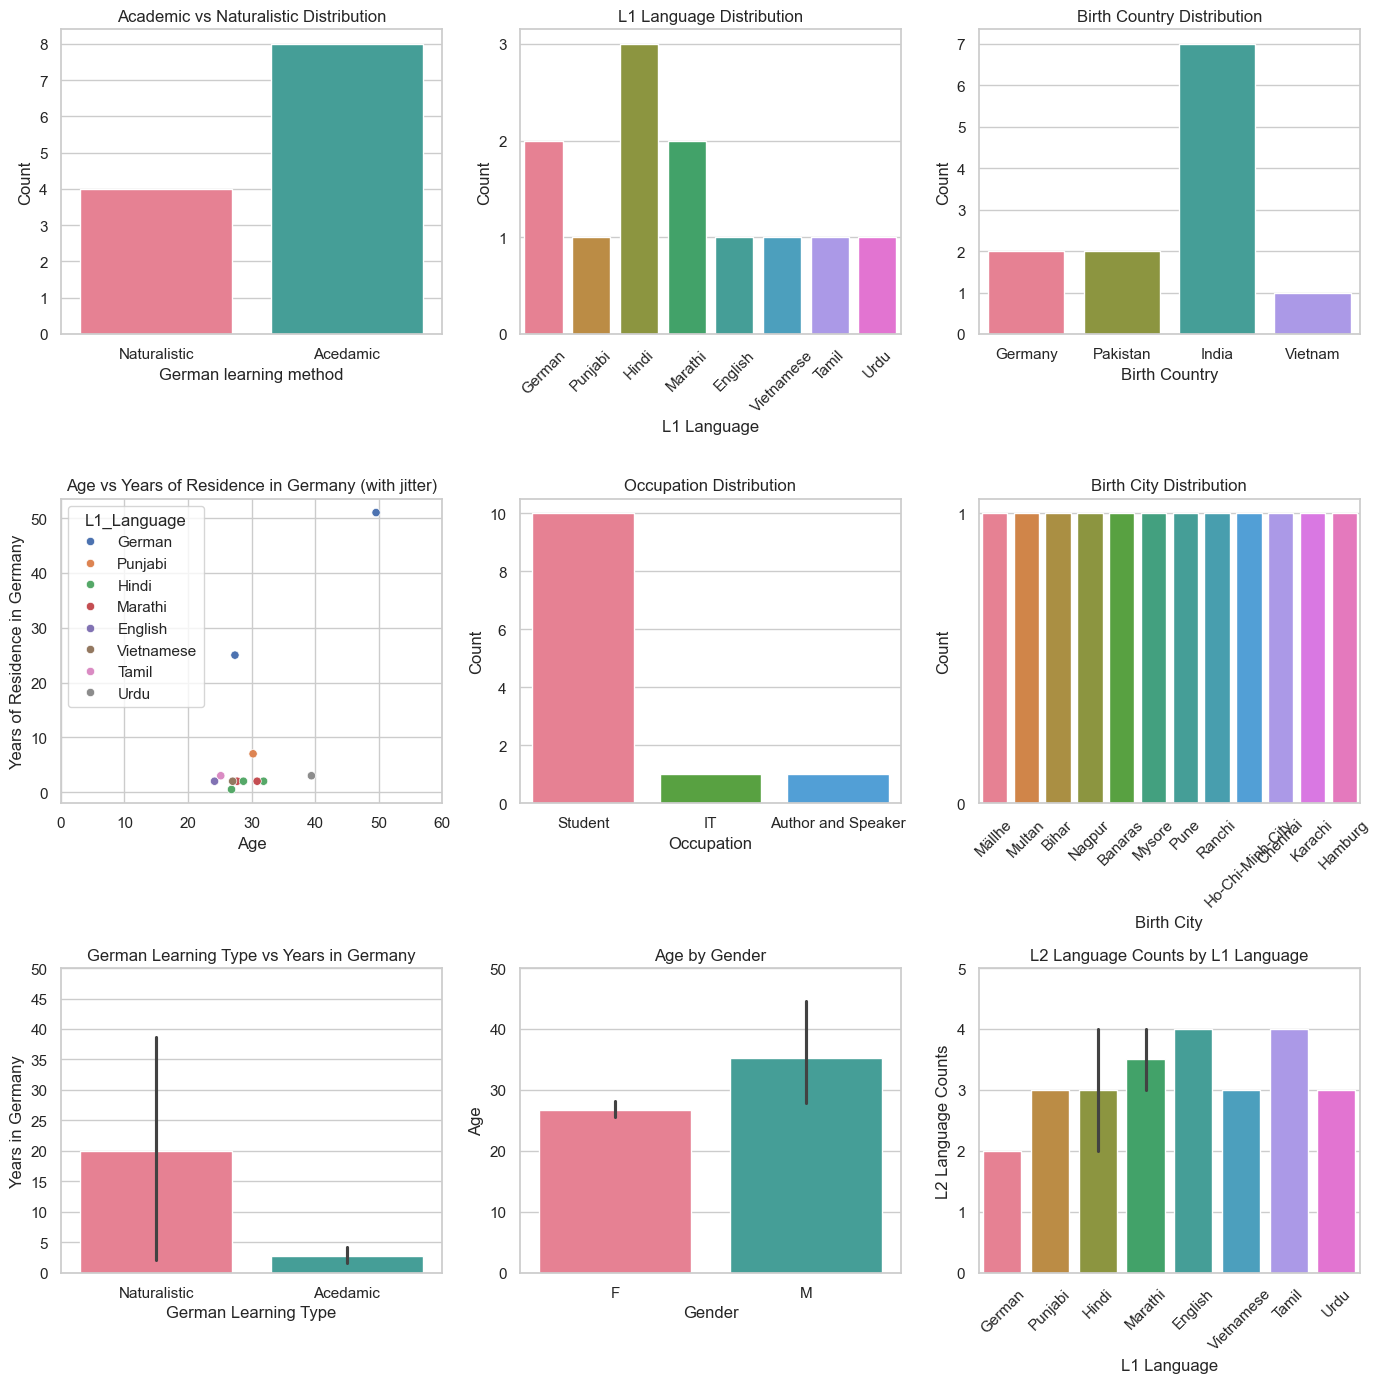

In [89]:
# Load the CSV file
file_path = 'data/00_speakers_data.csv'
df_full = pd.read_csv(file_path, encoding='utf-8-sig')
df = df_full[df_full['speaker_id'] != 'P11'].copy()


# Count occurrences of 'L2_Languages' column (other languages)
df['L2_Languages.counts'] = df['L2_Languages'].apply(lambda x: len(x.split(',')))

# Create a subplot with Seaborn
fig, axes = plt.subplots(3, 3, figsize=(14, 14))





# Plot 1: Academic vs Naturalistic Distribution

# Get unique number of German learning method
unique_counts = df['Ger_Learn_Method'].nunique()

# Create a larger custom palette or truncate as necessary
custom_palette = sns.color_palette("husl", unique_counts)  # Generates a distinct color palette

# Academic vs Naturalistic Distribution
sns.countplot(ax=axes[0, 0], x='Ger_Learn_Method', hue='Ger_Learn_Method', data=df, palette=custom_palette, dodge=False, legend=False)
axes[0, 0].set_title('Academic vs Naturalistic Distribution')
axes[0, 0].set_xlabel('German learning method')
axes[0, 0].set_ylabel('Count')





# Plot 2: L1 language Distribution

# Get unique number of L1 Language
unique_counts = df['L1_Language'].nunique()

# Create a larger custom palette or truncate as necessary
custom_palette = sns.color_palette("husl", unique_counts)  # Generates a distinct color palette

# L1 Language Distribution
sns.countplot(ax=axes[0, 1], x='L1_Language', hue='L1_Language', data=df, palette=custom_palette, dodge=False, legend=False)
axes[0, 1].set_title('L1 Language Distribution')
axes[0, 1].set_xlabel('L1 Language')
axes[0, 1].set_ylabel('Count')

# Set y-axis ticks in increments of 1
max_count = df['L1_Language'].value_counts().max()  # Get the maximum count to limit y-axis
axes[0, 1].set_yticks(np.arange(0, max_count + 1, 1))  # Set y-ticks in increments of 1


# Rotate x-tick labels for better readability
axes[0, 1].tick_params(axis='x', rotation=45)



# Plot 3: Birth Country Distribution

# Get unique number of L1 Language
unique_counts = df['Birth_Country'].nunique()

# Create a larger custom palette or truncate as necessary
custom_palette = sns.color_palette("husl", unique_counts)  # Generates a distinct color palette

# L1 Language Distribution
sns.countplot(ax=axes[0, 2], x='Birth_Country', hue='Birth_Country', data=df, palette=custom_palette, dodge=False, legend=False)
axes[0, 2].set_title('Birth Country Distribution')
axes[0, 2].set_xlabel('Birth Country')
axes[0, 2].set_ylabel('Count')








# Plot 4: Age vs Years in Germany
# Add jitter to the 'Age_yrs' column by adding a small random noise
df['Age_yrs_jittered'] = df['Age_yrs'] + np.random.uniform(-3, 3, size=len(df))

# Plot 4: Age vs Years in Germany with jitter
sns.scatterplot(ax=axes[1, 0], x='Age_yrs_jittered', y='Germany_Residence_yrs', hue='L1_Language', data=df)
axes[1, 0].set_title('Age vs Years of Residence in Germany (with jitter)')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Years of Residence in Germany')

# Set x-axis ticks in increments of 10
max_age = df['Age_yrs'].max()  # Get the maximum value of 'Age_yrs'
axes[1, 0].set_xticks(np.arange(0, max_age + 10, 10))  # Set x-ticks in increments of 10



# Plot 5: Occupation Distribution

# Get unique occupations to match the palette size
unique_counts = df['Occupation'].nunique()

# Create a larger custom palette or truncate as necessary
custom_palette = sns.color_palette("husl", unique_counts)  # Generates a distinct color palette

# Occupation Distribution
sns.countplot(ax=axes[1, 1], x='Occupation', hue='Occupation', data=df, palette=custom_palette, dodge=False, legend=False)
axes[1, 1].set_title('Occupation Distribution')
axes[1, 1].set_xlabel('Occupation')
axes[1, 1].set_ylabel('Count')



# Plot 6: Birth City Distribution

# Get unique number of birth cities
unique_counts = df['Birth_City'].nunique()

# Create a larger custom palette or truncate as necessary
custom_palette = sns.color_palette("husl", unique_counts)  # Generates a distinct color palette

#Birth City Distribution
sns.countplot(ax=axes[1, 2], x='Birth_City', hue='Birth_City', data=df, palette=custom_palette, dodge=False, legend=False)
axes[1, 2].set_title('Birth City Distribution')
axes[1, 2].set_xlabel('Birth City')
axes[1, 2].set_ylabel('Count')

# Set y-axis ticks in increments of 1
max_count = df['Birth_City'].value_counts().max()  # Get the maximum count to limit y-axis
axes[1, 2].set_yticks(np.arange(0, max_count + 1, 1))  # Set y-ticks in increments of 1

# Rotate x-tick labels for better readability
axes[1, 2].tick_params(axis='x', rotation=45)





# Plot 7: German Learning Type vs Years in Germany.
# Get unique count for the custom palette
unique_counts = df['Ger_Learn_Method'].nunique()

# Create a color palette for the unique Ger_Learn_Method
custom_palette = sns.color_palette("husl", unique_counts)  # Generates a distinct color palette

#  Counts by Ger_Learn_Method (with hue)
sns.barplot(ax=axes[2, 0], x='Ger_Learn_Method', y='Germany_Residence_yrs', hue='Ger_Learn_Method', data=df, palette=custom_palette, dodge=False, legend=False)

axes[2, 0].set_title('German Learning Type vs Years in Germany')
axes[2, 0].set_xlabel('German Learning Type')
axes[2, 0].set_ylabel('Years in Germany')

# Set y-axis increments to 10
max_age = df['Germany_Residence_yrs'].max()  # Get the maximum value of 'age'
axes[2, 0].set_yticks(np.arange(0, max_age + 1, 5))  # Set y-ticks in increments of 10





# Plot 8: Counts by Gender (with hue)
# Get unique Gender for the custom palette
unique_counts = df['Gender'].nunique()

# Create a color palette for the unique Gender
custom_palette = sns.color_palette("husl", unique_counts)  # Generates a distinct color palette

#  Counts by Gender (with hue)
sns.barplot(ax=axes[2, 1], x='Gender', y='Age_yrs', hue='Gender', data=df, palette=custom_palette, dodge=False, legend=False)

axes[2, 1].set_title('Age by Gender')
axes[2, 1].set_xlabel('Gender')
axes[2, 1].set_ylabel('Age')

# Set y-axis increments to 10
max_age = df['Age_yrs'].max()  # Get the maximum value of 'age'
axes[2, 1].set_yticks(np.arange(0, max_age + 1, 10))  # Set y-ticks in increments of 10






# Plot 9: L2 Language Counts by Native Language
# Get unique native languages for the custom palette
unique_counts = df['L1_Language'].nunique()

# Create a color palette for the unique native languages
custom_palette = sns.color_palette("husl", unique_counts)  # Generates a distinct color palette

# Plot 3: Other Language Counts by Native Language (with hue)
sns.barplot(ax=axes[2, 2], x='L1_Language', y='L2_Languages.counts', hue='L1_Language', data=df, palette=custom_palette, dodge=False, legend=False)

axes[2, 2].set_title('L2 Language Counts by L1 Language')
axes[2, 2].set_xlabel('L1 Language')
axes[2, 2].set_ylabel('L2 Language Counts')

# Set y-axis increments to 1
max_othLang_counts = df['L2_Languages.counts'].max()  # Get the maximum value of 'othLang.counts'
axes[2, 2].set_yticks(np.arange(0, max_othLang_counts + 2, 1))  # Set y-ticks in increments of 1

# Rotate x-tick labels for better readability (optional, if labels overlap)
axes[2, 2].tick_params(axis='x', rotation=45)





# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()



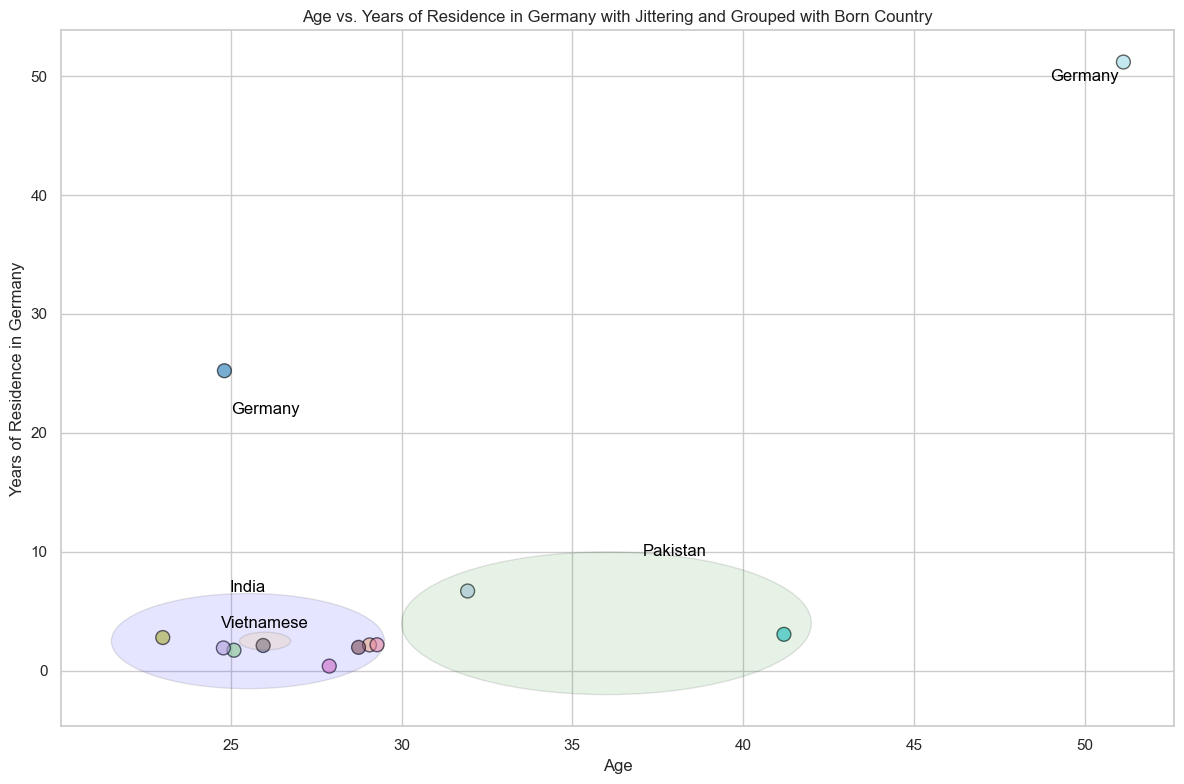

In [201]:
# Sample data loading and preparation
file_to_analyze = 'data/06_added_list_sums.csv'
df = pd.read_csv(file_to_analyze, delimiter=',', encoding='utf-8-sig')
df_vosk = df[df['Library'] == 'Assembly.AI']

# Add jittering to the scatter plot
jitter_strength = 0.3
age_jittered = df_vosk['Age_yrs'] + np.random.uniform(-jitter_strength, jitter_strength, df_vosk.shape[0])
ger_res_yrs_jittered = df_vosk['Germany_Residence_yrs'] + np.random.uniform(-jitter_strength, jitter_strength, df_vosk.shape[0])

# Create scatter plot with jittering and transparency
plt.figure(figsize=(12, 8))
colors = plt.get_cmap('tab20').colors  # Use a colormap with multiple colors
plt.scatter(age_jittered, ger_res_yrs_jittered, c=np.arange(len(df_vosk)), s=100, alpha=0.6, edgecolors='black', cmap='tab20')

# Define positions for custom shapes and labels
custom_positions = [
    {'x': 26, 'y': 22, 'text': 'Germany', 'color': 'red', 'size': 100, 'shape': 'circle', 'alpha': 0.1},
    {'x': 50, 'y': 50, 'text': 'Germany', 'color': 'red', 'size': 100, 'shape': 'circle', 'alpha': 0.1},

    {'x': 25.5, 'y': 7, 'text': 'India', 'color': 'blue', 'size': 100, 'shape': 'rectangle', 'alpha': 0.1},
    {'x': 38, 'y': 10, 'text': 'Pakistan', 'color': 'green', 'size': 100, 'shape': 'circle', 'alpha': 0.1},
    {'x': 26, 'y': 4, 'text': 'Vietnamese', 'color': 'orange', 'size': 100, 'shape': 'circle', 'alpha': 0.1},    
]

# Add custom shapes and text
for pos in custom_positions:
    if pos['text'] == 'Germany':
        circle = patches.Circle((pos['x'], pos['y']+3.5), radius=3, edgecolor='black', facecolor=pos['color'], alpha=pos['alpha'])
        #plt.gca().add_patch(circle)
    elif pos['text'] == 'India':
        circle = patches.Circle((pos['x'], pos['y']-4.5), radius=4, edgecolor='black', facecolor=pos['color'], alpha=pos['alpha'])
        plt.gca().add_patch(circle)
    elif pos['text'] == 'Pakistan':
        circle = patches.Circle((pos['x']-2, pos['y']-6), radius=6, edgecolor='black', facecolor=pos['color'], alpha=pos['alpha'])
        plt.gca().add_patch(circle)
    elif pos['text'] == 'Vietnamese':
        circle = patches.Circle((pos['x'], pos['y']-1.5), radius=0.75, edgecolor='black', facecolor=pos['color'], alpha=pos['alpha'])
        plt.gca().add_patch(circle)
                                

    
    plt.text(pos['x'], pos['y'], pos['text'], fontsize=12, ha='center', va='center', color='black')



plt.title("Age vs. Years of Residence in Germany with Jittering and Grouped with Born Country")
plt.xlabel("Age")
plt.ylabel("Years of Residence in Germany")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
# Load the CSV file
file_to_analyze = 'data/07_WER_merged.csv'
df = pd.read_csv(file_to_analyze)


In [202]:
# Load the CSV file
file_to_analyze = 'data/07_WER_merged.csv'
df = pd.read_csv(file_to_analyze)

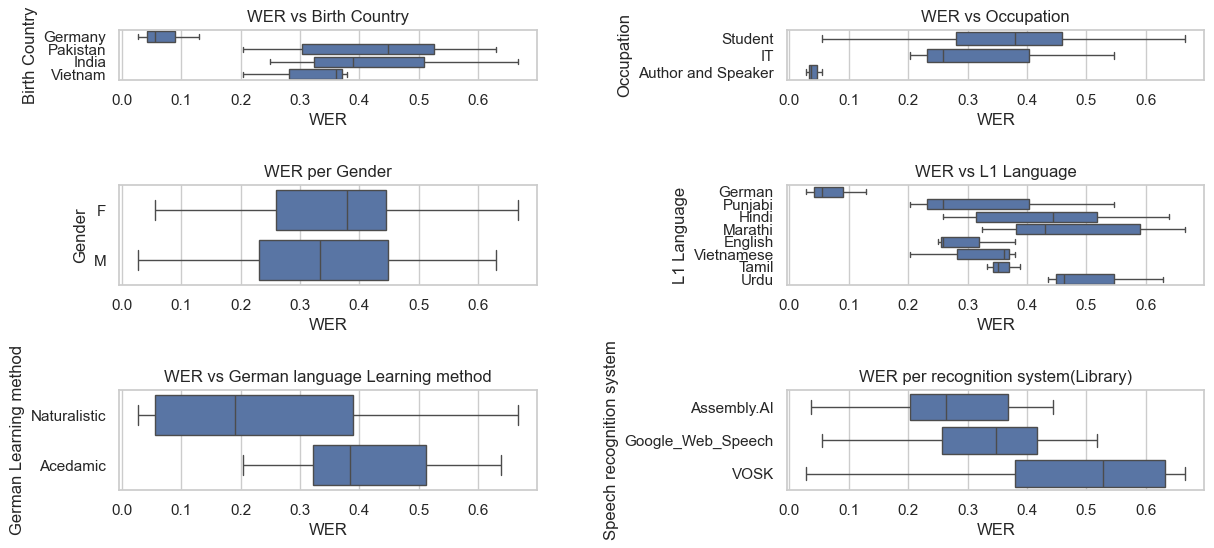

In [227]:


# Create a figure with GridSpec to control width and height ratios
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(5, 2, width_ratios=[1, 1], height_ratios=[1, 2, 2,1,1])  # Adjust width and height ratios

# Adjustment of spacing
plt.subplots_adjust(wspace=.6, hspace=1.5)  # wspace controls width space, hspace controls height space

# 1 Plot: WER vs. Birth Country 
ax1 = fig.add_subplot(gs[0, 0])  # First row, second column 
sns.boxplot(x='WER', y=dfa['Birth_Country'], data=dfa, ax=ax1)
ax1.set_title('WER vs Birth Country')
ax1.set_xlabel('WER')
ax1.set_ylabel('Birth Country')

# 2 Plot: WER vs. Occupation 
ax3 = fig.add_subplot(gs[0, 1])  
sns.boxplot(x='WER', y=dfa['Occupation'], data=dfa, ax=ax3)
ax3.set_title('WER vs Occupation')
ax3.set_xlabel('WER')
ax3.set_ylabel('Occupation')

# 3 Plot: WER vs. Gender 
ax5 = fig.add_subplot(gs[1, 0])  
sns.boxplot(x='WER', y=dfa['Gender'], data=dfa, ax=ax5)
ax5.set_title('WER per Gender')
ax5.set_xlabel('WER')
ax5.set_ylabel('Gender')




# 4 Plot: WER vs. nativeLang 
ax9 = fig.add_subplot(gs[1, 1])  
sns.boxplot(x='WER', y=dfa['L1_Language'], data=dfa, ax=ax9)
ax9.set_title('WER vs L1 Language')
ax9.set_xlabel('WER')
ax9.set_ylabel('L1 Language')


# 5 Plot: WER vs. GerLearn 
ax7 = fig.add_subplot(gs[2, 0])  
sns.boxplot(x='WER', y=dfa['Ger_Learn_Method'], data=dfa, ax=ax7)
ax7.set_title('WER vs German language Learning method')
ax7.set_xlabel('WER')
ax7.set_ylabel('German Learning method')


# 6th Plot
ax6 = fig.add_subplot(gs[2, 1])  # First row, second column 
sns.boxplot(x='WER', y=dfa['Library'], data=dfa, ax=ax6)
ax6.set_title('WER per recognition system(Library)')
ax6.set_xlabel('WER')
ax6.set_ylabel('Speech recognition system')


# Display the plot
plt.show()


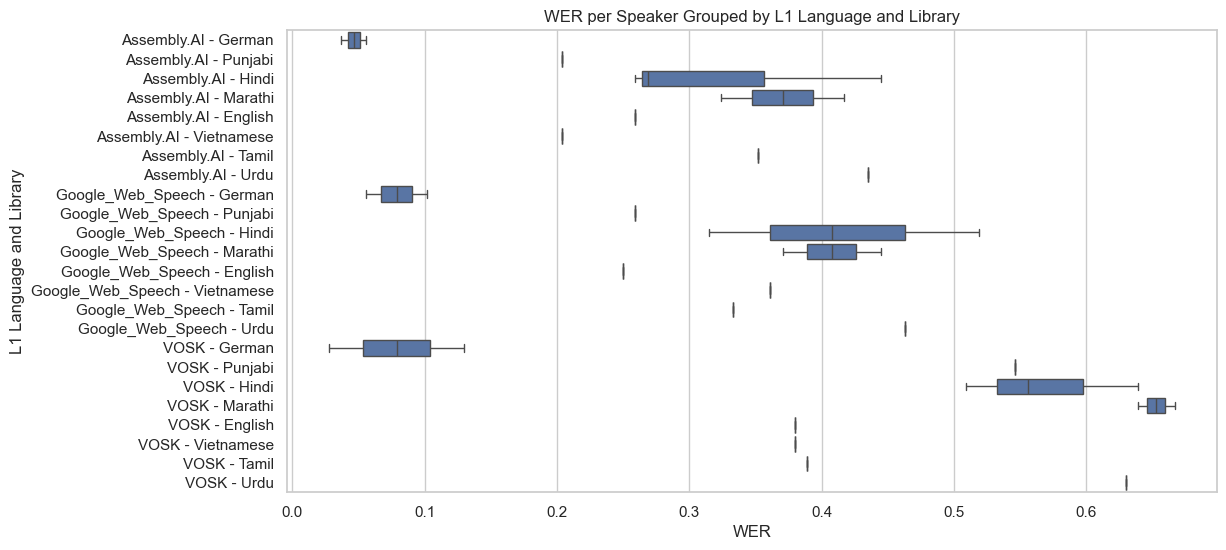

In [268]:
dfa = df # Filter the data by Library if needed

# Create a new column combining nativeLang and Library for grouping
dfa['Group'] =dfa['Library'] + ' - ' +  dfa['L1_Language']

# Plotting boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='WER', y=dfa['Group'], data=dfa)

plt.title('WER per Speaker Grouped by L1 Language and Library')
plt.xlabel('WER')
plt.ylabel('L1 Language and Library')

plt.show()


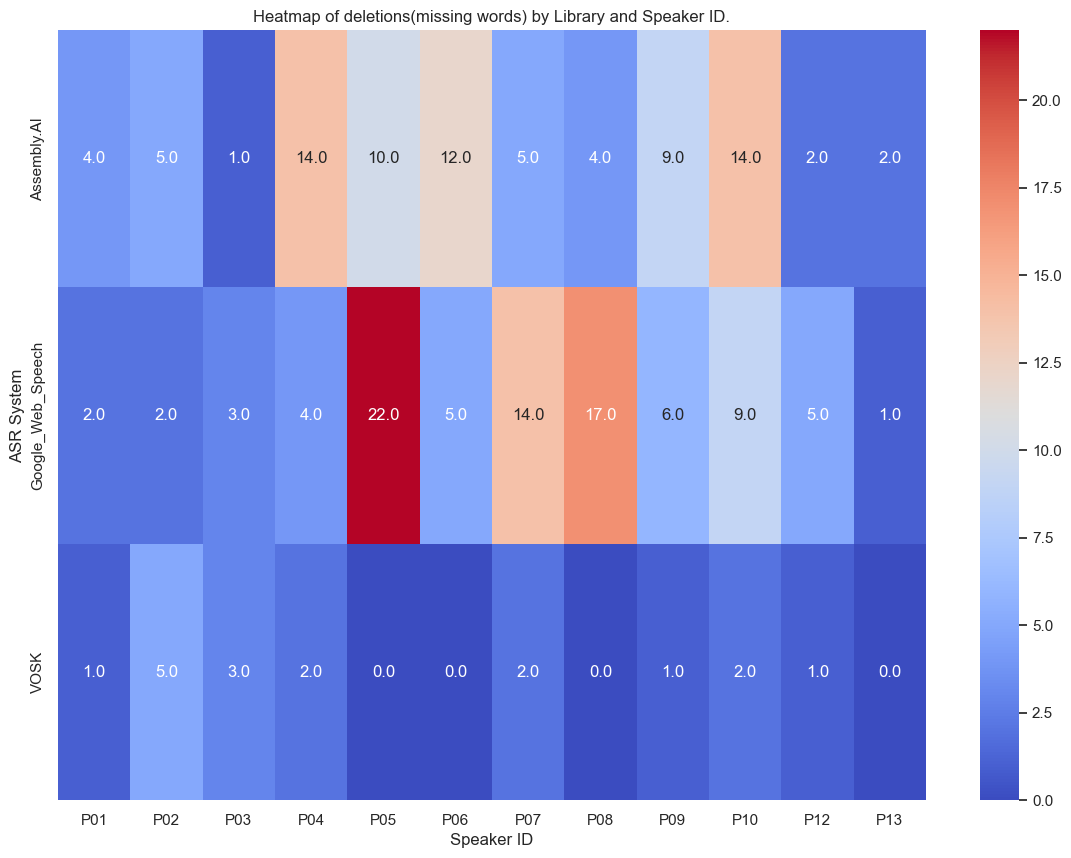

In [233]:
# Load the CSV file
file_to_analyze = 'data/07_WER_merged.csv'
df = pd.read_csv(file_to_analyze, delimiter=',', encoding='utf-8-sig')

# Choose a metric to visualize
metric = 'empty_cells'

# Pivot the data: Use the metric as values, 'Library' as rows, and 'speaker_id' as columns
pivot_table = df.pivot(index='Library', columns='speaker_id', values=metric)

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".1f")
plt.title(f'Heatmap of deletions(missing words) by Library and Speaker ID.')
plt.xlabel('Speaker ID')
plt.ylabel('ASR System')
plt.show()


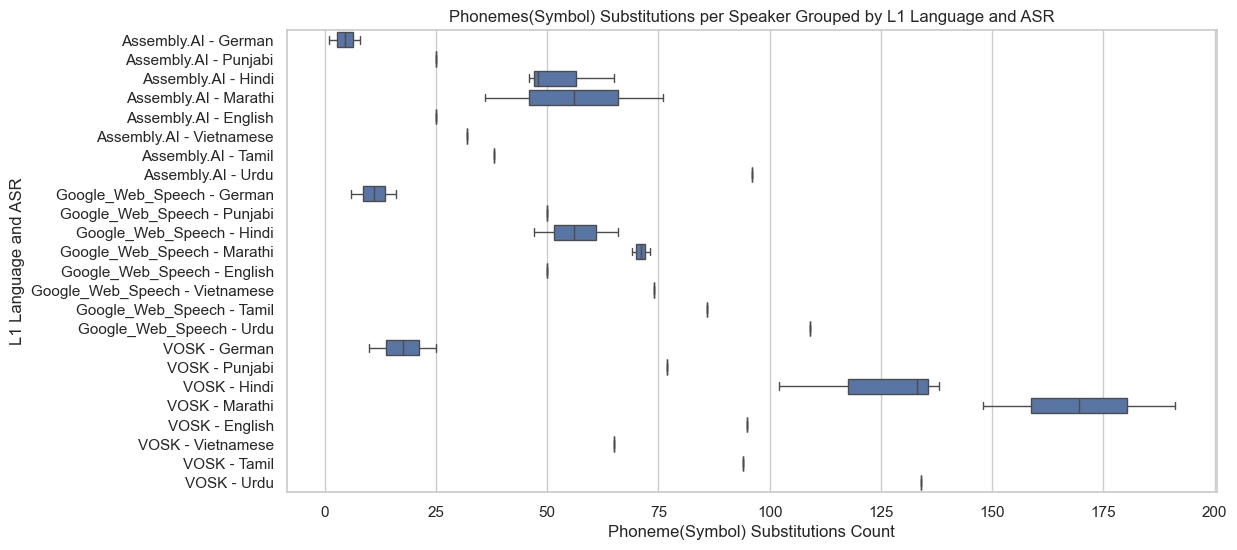

In [269]:
dfa = df # Filter the data by Library if needed

# Create a new column combining nativeLang and Library for grouping
dfa['Group'] =dfa['Library'] + ' - ' +  dfa['L1_Language']

# Plotting boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='wrong_p_sum', y=dfa['Group'], data=dfa)

plt.title('Phonemes(Symbol) Substitutions per Speaker Grouped by L1 Language and ASR')
plt.xlabel('Phoneme(Symbol) Substitutions Count')
plt.ylabel('L1 Language and ASR')

plt.show()


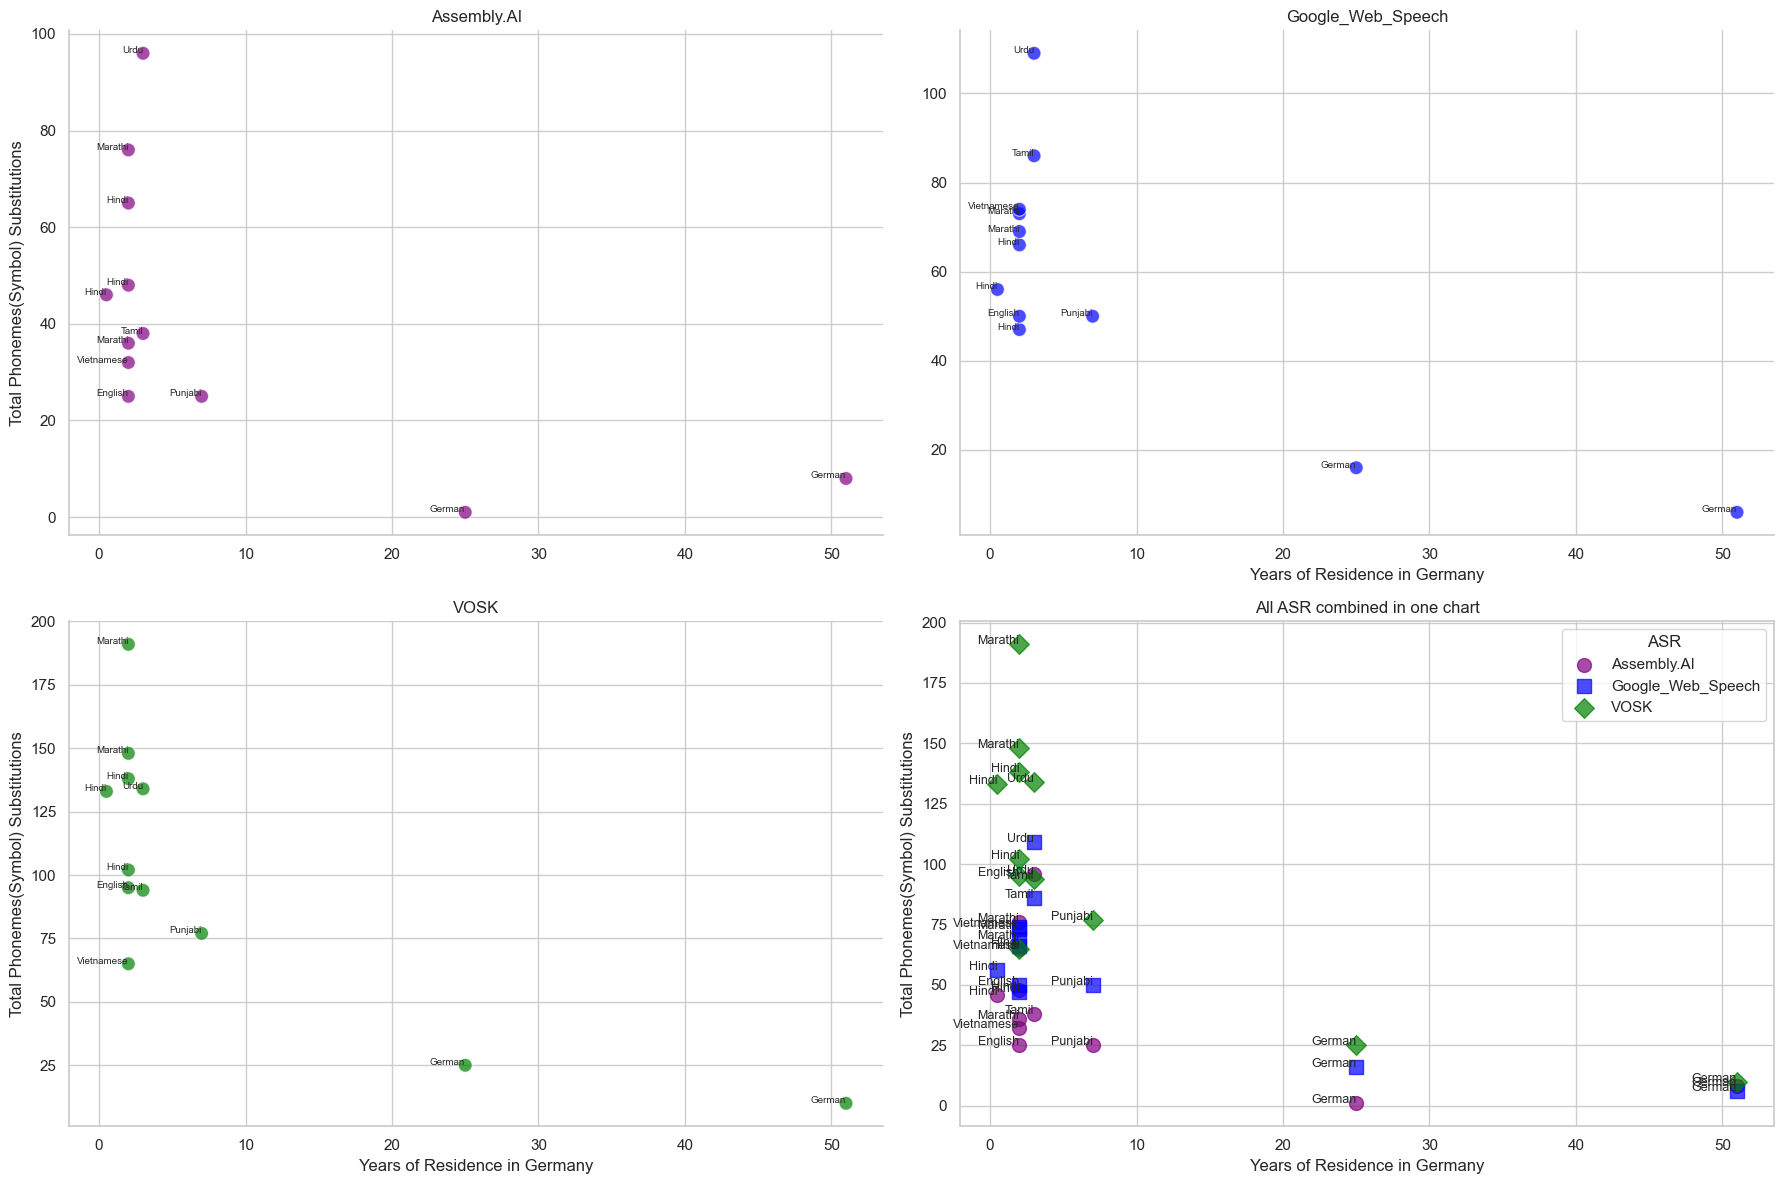

In [267]:
# Load the CSV file
file_to_analyze = 'data/07_WER_merged.csv'
df = pd.read_csv(file_to_analyze, delimiter=',', encoding='utf-8-sig')

# Define a color map for each library
library_colors = {
    'Assembly.AI': 'purple',
    'Google_Web_Speech': 'blue',
    'VOSK': 'green'
}

# Create a new column in the DataFrame for colors
df['color'] = df['Library'].map(library_colors)

# Create the first 3 plots in a Seaborn FacetGrid
g = sns.FacetGrid(df, col="Library", col_wrap=2, height=6, aspect=1, sharex=False, sharey=False)

# Function to create scatter plots
def scatter_plot(data, **kwargs):
    sns.scatterplot(data=data, x='Germany_Residence_yrs', y='wrong_p_sum', hue='Library', palette=library_colors, s=100, alpha=0.7, **kwargs)
    for i, row in data.iterrows():
        plt.text(row['Germany_Residence_yrs'], row['wrong_p_sum'], row['L1_Language'], fontsize=7, ha='right')

# Apply scatter plot function to each subset in the grid
g.map_dataframe(scatter_plot)

# Add titles and labels
g.set_axis_labels('Years of Residence in Germany', 'Total Phonemes(Symbol) Substitutions')
g.set_titles(col_template="{col_name}")

#4th chart outside of the Seaborn grid using plt.subplot

# Create a new figure to accommodate the grid and an additional subplot
fig = plt.gcf()  # Get the current figure used by Seaborn grid
fig.set_size_inches(18, 12)  # Adjust size to fit the extra chart

# Add a 4th plot using plt.subplot
ax = plt.subplot(2, 2, 4)  # Placing the 4th plot in the bottom right position

# Define a color map and marker styles for each library
library_styles = {
    'Assembly.AI': {'color': 'purple', 'marker': 'o'},
    'Google_Web_Speech': {'color': 'blue', 'marker': 's'},
    'VOSK': {'color': 'green', 'marker': 'D'}
}

# Plot data for each library in the 4th subplot
for library, style in library_styles.items():
    dfl = df[df['Library'] == library]  # Filter by Library
    ax.scatter(dfl['Germany_Residence_yrs'], dfl['wrong_p_sum'],
               color=style['color'], marker=style['marker'],
               s=100, alpha=0.7, label=library)
    
    # Add labels for nativeLang
    for i, row in dfl.iterrows():
        ax.text(row['Germany_Residence_yrs'], row['wrong_p_sum'], row['L1_Language'], fontsize=9, ha='right')

# Add labels, title, legend, and grid to the 4th chart
ax.set_title('All ASR combined in one chart')
ax.set_xlabel('Years of Residence in Germany')
ax.set_ylabel('Total Phonemes(Symbol) Substitutions')
ax.legend(title='ASR')
ax.grid(True)

# Adjust layout to avoid overlapping of plots
plt.tight_layout()

# Display all charts
plt.show()


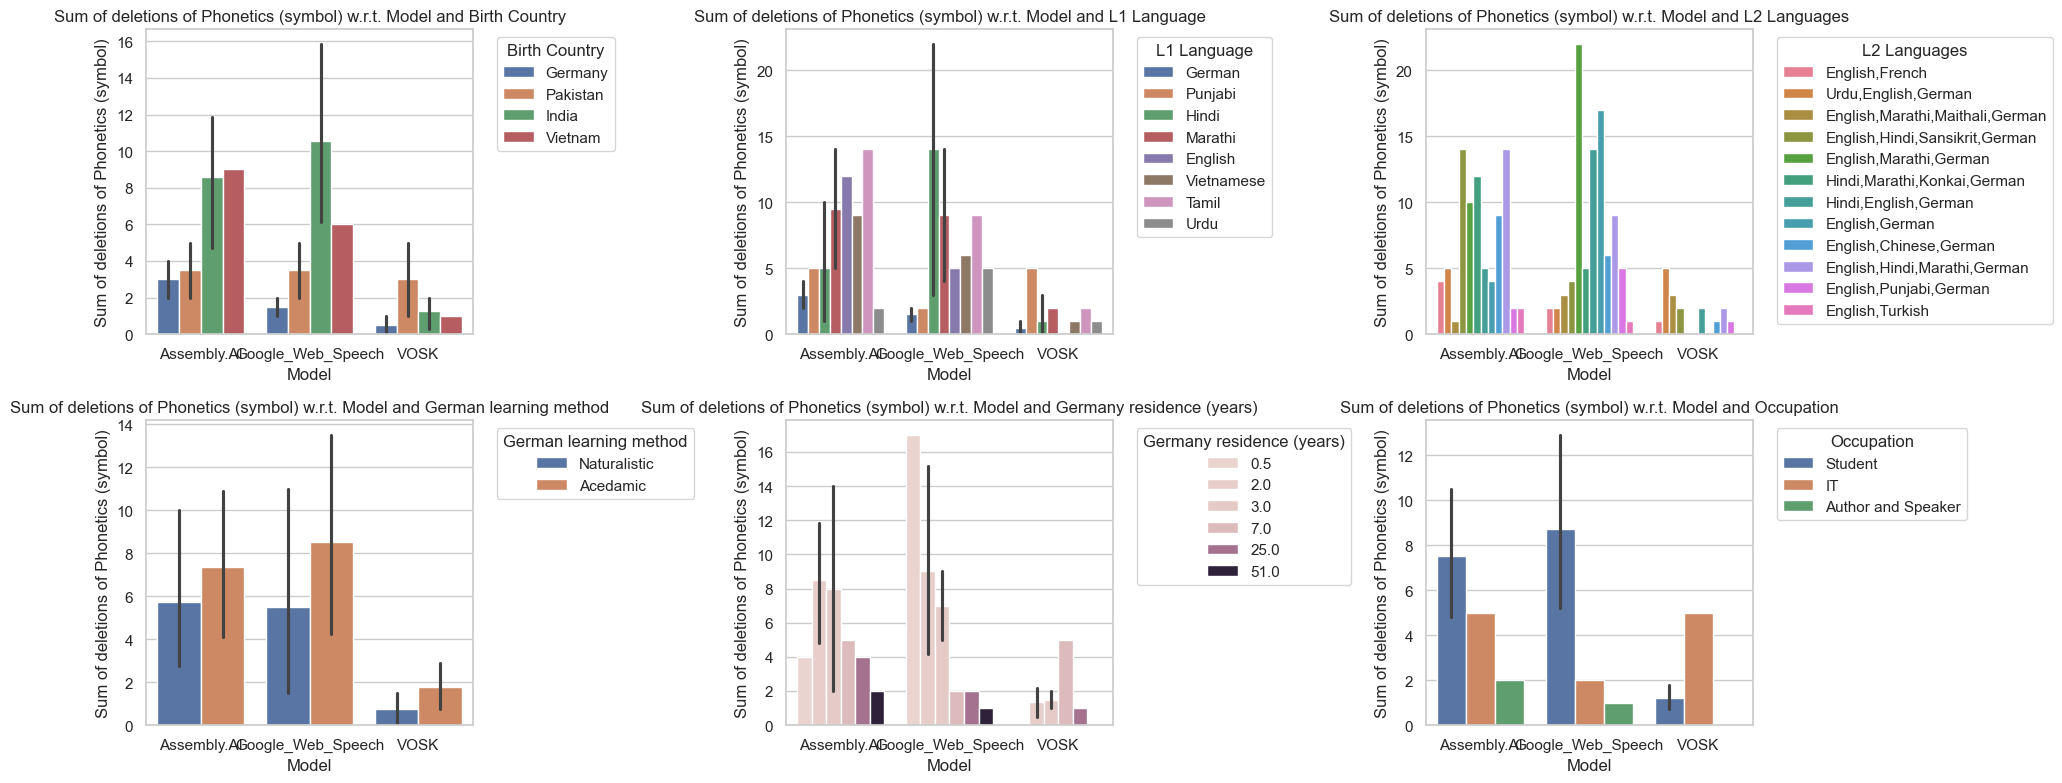

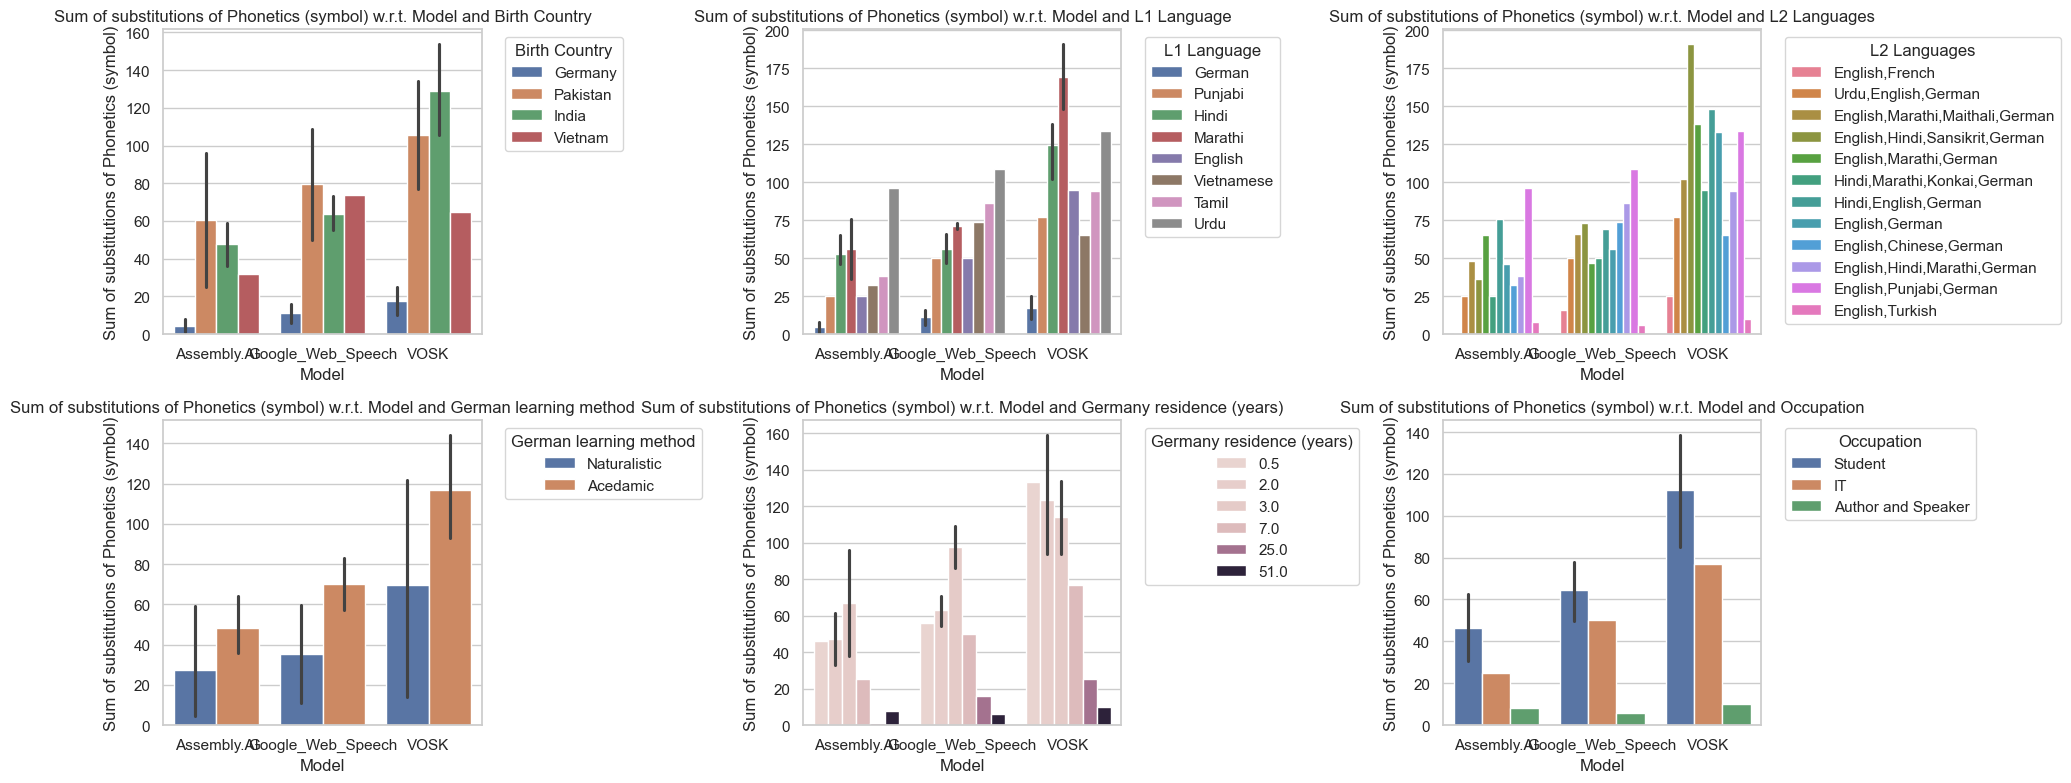

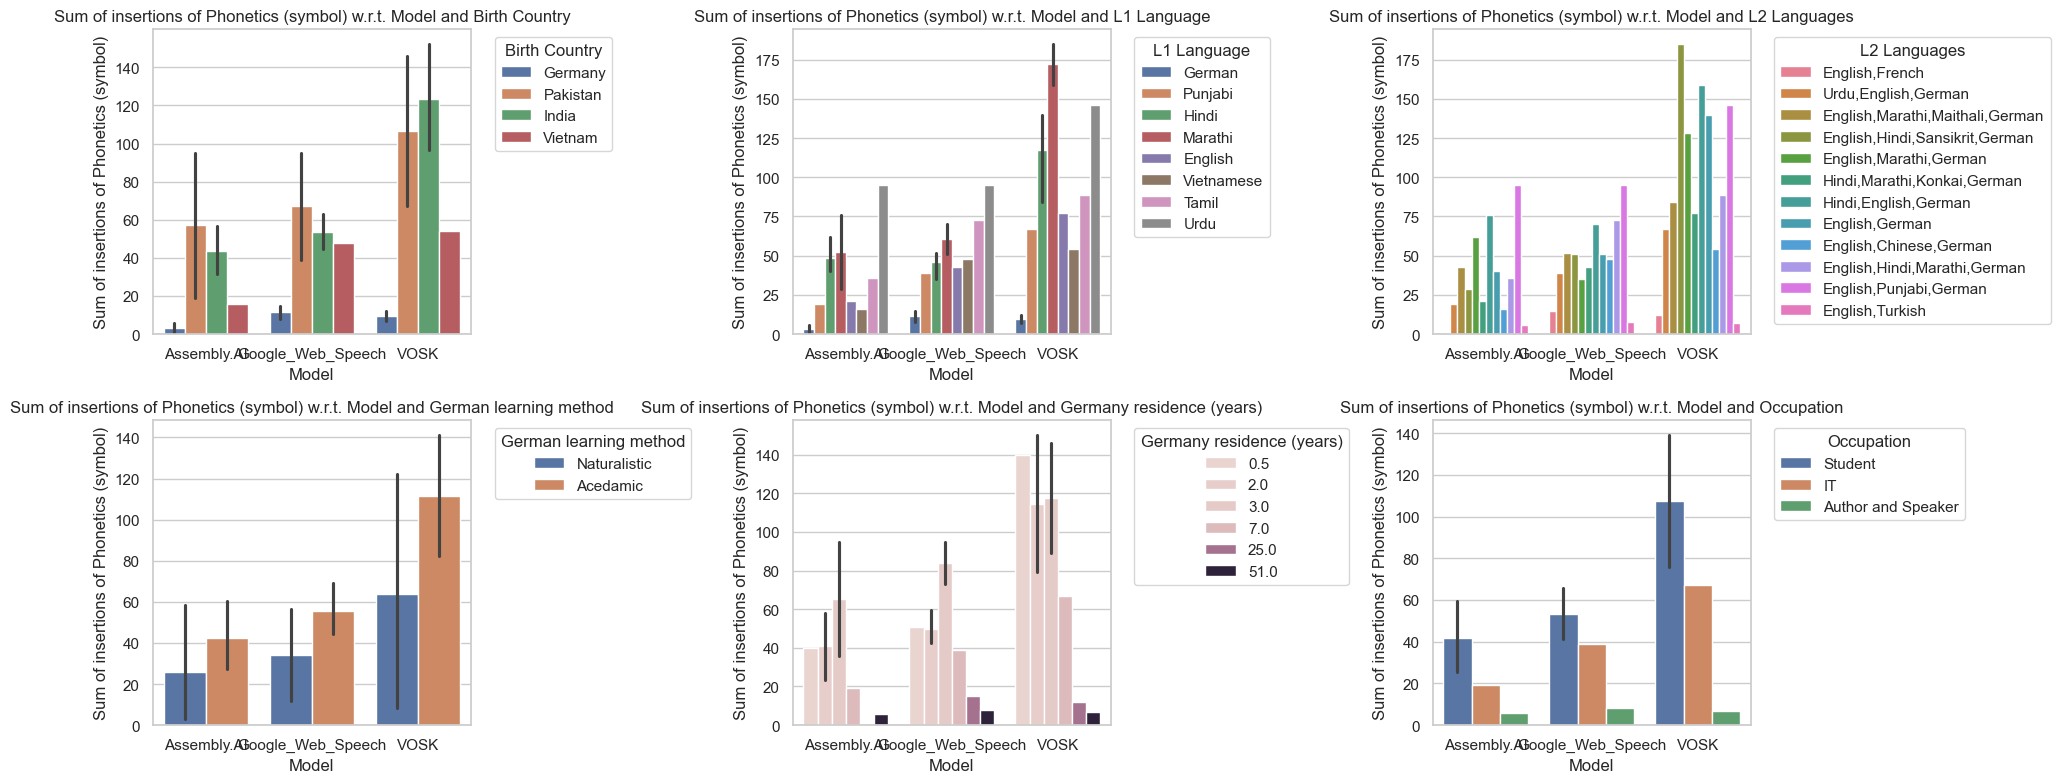

In [284]:
# Define y-axis metrics
metrics = ['empty_cells', 'wrong_p_sum', 'extra_spoken_p_sum']

# Define categories to group by
categories = ['Birth_Country', 'L1_Language', 'L2_Languages', 'Ger_Learn_Method', 'Germany_Residence_yrs', 'Occupation']

# Define legend labels
legend_labels = ['Birth Country', 'L1 Language', 'L2 Languages', 'German learning method', 'Germany residence (years)', 'Occupation']

# Define metric titles
metric_title = ['Sum of deletions of Phonetics (symbol)', 
                'Sum of substitutions of Phonetics (symbol)', 
                'Sum of insertions of Phonetics (symbol)']

# Set the style for the plots
sns.set(style="whitegrid")

# Function to create a 3x3 subplot for a specific metric
def create_subplots_for_metric(df, metric, categories, legend_labels, title):
    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))  # Adjust

    # Enumerate over categories and plot on subplots
    for i, category in enumerate(categories):  # Enumerate over categories
        # Calculate the row and column index for the subplot
        row = i // 3  # Integer division for row
        col = i % 3   # Modulus for column
        
        if row >= 3:  # Limit to only 9 plots (3x3)
            break
        
        # Select the subplot axis
        ax = axes[row, col]
        
        # Create the bar chart on the respective subplot axis
        sns.barplot(x='Library', y=metric, hue=category, data=df, ax=ax)
        
        # Set chart title and labels
        ax.set_title(f'{title} w.r.t. Model and {legend_labels[i]}')
        ax.set_ylabel(title)
        ax.set_xlabel('Model')
        
        # Display the legend outside of the plot area
        ax.legend(title=legend_labels[i], bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust the layout to avoid overlap and tight fit
    plt.tight_layout()
    plt.show()

# Call the function to generate subplots for the first metric
create_subplots_for_metric(df, metrics[0], categories, legend_labels, metric_title[0])

# Repeat for the second metric
create_subplots_for_metric(df, metrics[1], categories, legend_labels, metric_title[1])

# Repeat for the third metric
create_subplots_for_metric(df, metrics[2], categories, legend_labels, metric_title[2])


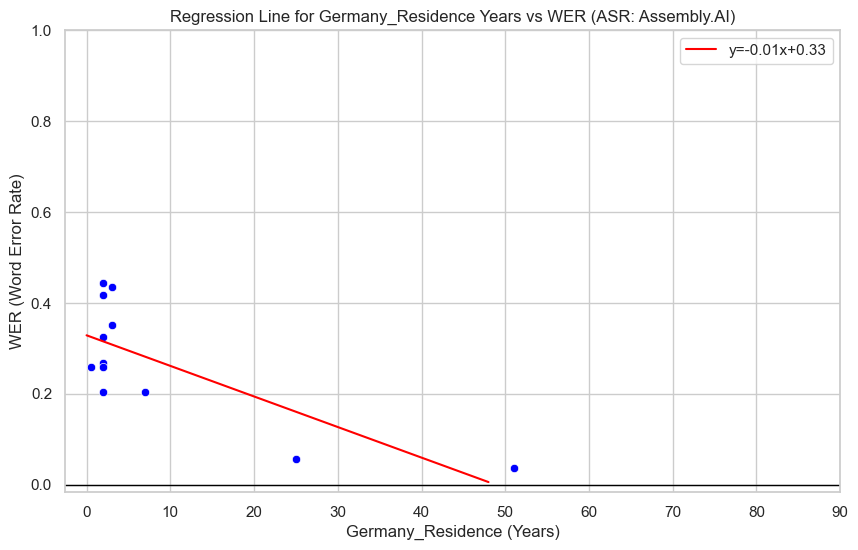

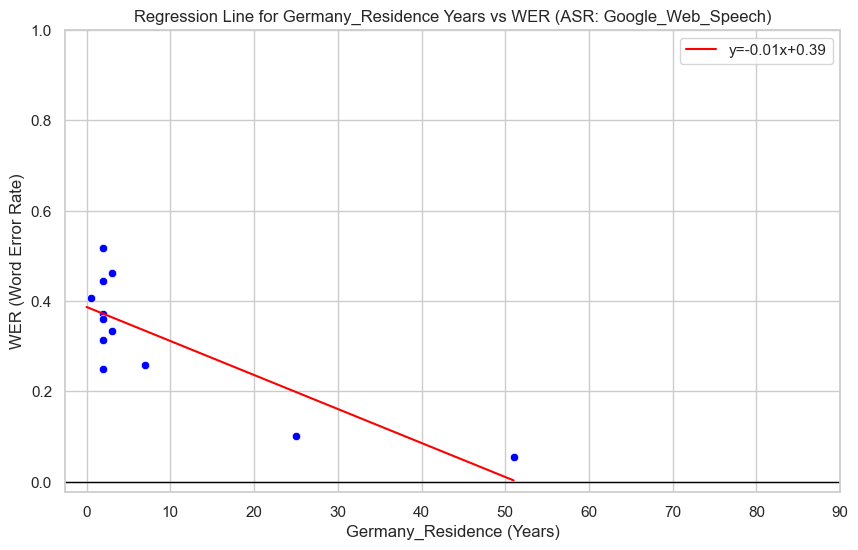

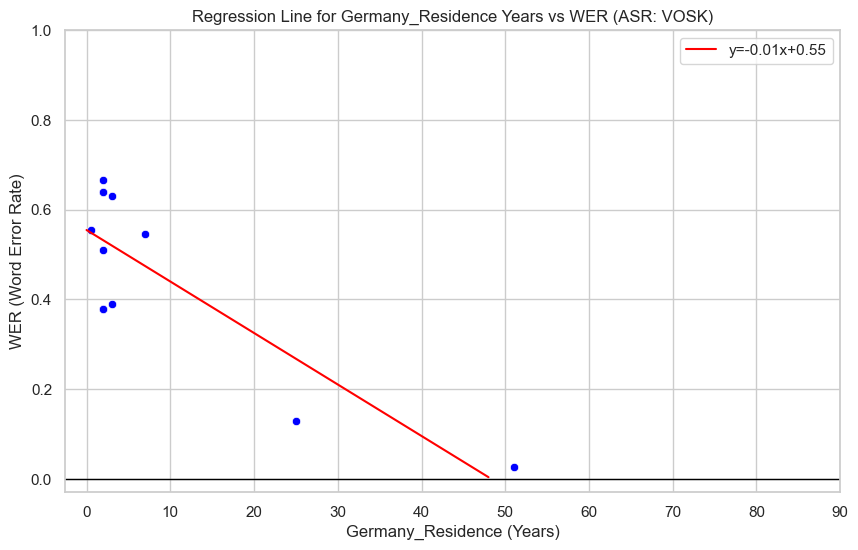

In [292]:


# Load the CSV file
file_path = 'data/07_WER_merged.csv'  # Adjust the path to where your CSV is located
data = pd.read_csv(file_path)

# Define the list of libraries to plot
libraries = ['Assembly.AI', 'Google_Web_Speech', 'VOSK']

# Loop over each library and create a chart
for library in libraries:
    # Filter data for the current library
    filtered_data = data[data['Library'] == library]
    
    # Fit a regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_data['Germany_Residence_yrs'], filtered_data['WER'])
    
    # Calculate the x-intercept (where y=0)
    x_intercept = -intercept / slope
    
    # Create an extended range of x values to include the x-intercept
    x_vals = pd.Series(range(0, int(x_intercept) + 1))
    
    # Calculate the corresponding y values using the regression equation
    regression_line = slope * x_vals + intercept
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Scatter plot of original data
    sns.scatterplot(x='Germany_Residence_yrs', y='WER', data=filtered_data, color='blue')
    
    # Plot the extended regression line
    plt.plot(x_vals, regression_line, color='red', label=f"y={slope:.2f}x+{intercept:.2f}")
    
    # Set x and y axis intervals
    plt.xticks(range(0, 100, 10))
    plt.yticks([i/10 for i in range(0, 11, 2)])
    
    # Labels and title
    plt.xlabel('Germany_Residence (Years)')
    plt.ylabel('WER (Word Error Rate)')
    plt.title(f'Regression Line for Germany_Residence Years vs WER (ASR: {library})')
    
    # Add legend
    plt.legend()
    
    # Show grid and plot
    plt.grid(True)
    plt.axhline(0, color='black', linewidth=1)  # Add x-axis line for reference
    
    # Show the plot
    plt.show()


### Charts for Transcription Errors due to lack of phenomes in L1 inventory

In [262]:
def prepare_data(df):
    data = []
    
    # Get the count of speakers for each language
    speaker_counts = df['L1_Language'].value_counts()

    for lang in df['L1_Language'].unique():
        dfl = df[df['L1_Language'] == lang]

        # Initialize phoneme counts
        phoneme_counts = {phoneme: 0 for phoneme in phenome_space}

        for _, row in dfl.iterrows():
            phonemes = eval(row['wrong_p_dict'])  # Convert string representation to dictionary
            for phoneme, count in phonemes.items():
                if phoneme in phenome_space:
                    phoneme_counts[phoneme] += count

        # Divide the counts by the number of speakers for this language
        num_speakers = speaker_counts[lang]
        phoneme_counts = {phoneme: np.ceil(count / num_speakers) for phoneme, count in phoneme_counts.items()}
        
        # Convert phoneme counts to DataFrame
        phoneme_df = pd.DataFrame(list(phoneme_counts.items()), columns=['Phoneme', 'Count'])
        phoneme_df[['X_axis', 'Y_axis']] = phoneme_df['Phoneme'].map(phenome_space).apply(pd.Series)

        # Pivot table for heatmap
        matrix = phoneme_df.pivot(index='Y_axis', columns='X_axis', values='Count')#.fillna(0)
        data.append((lang, matrix))

    return data


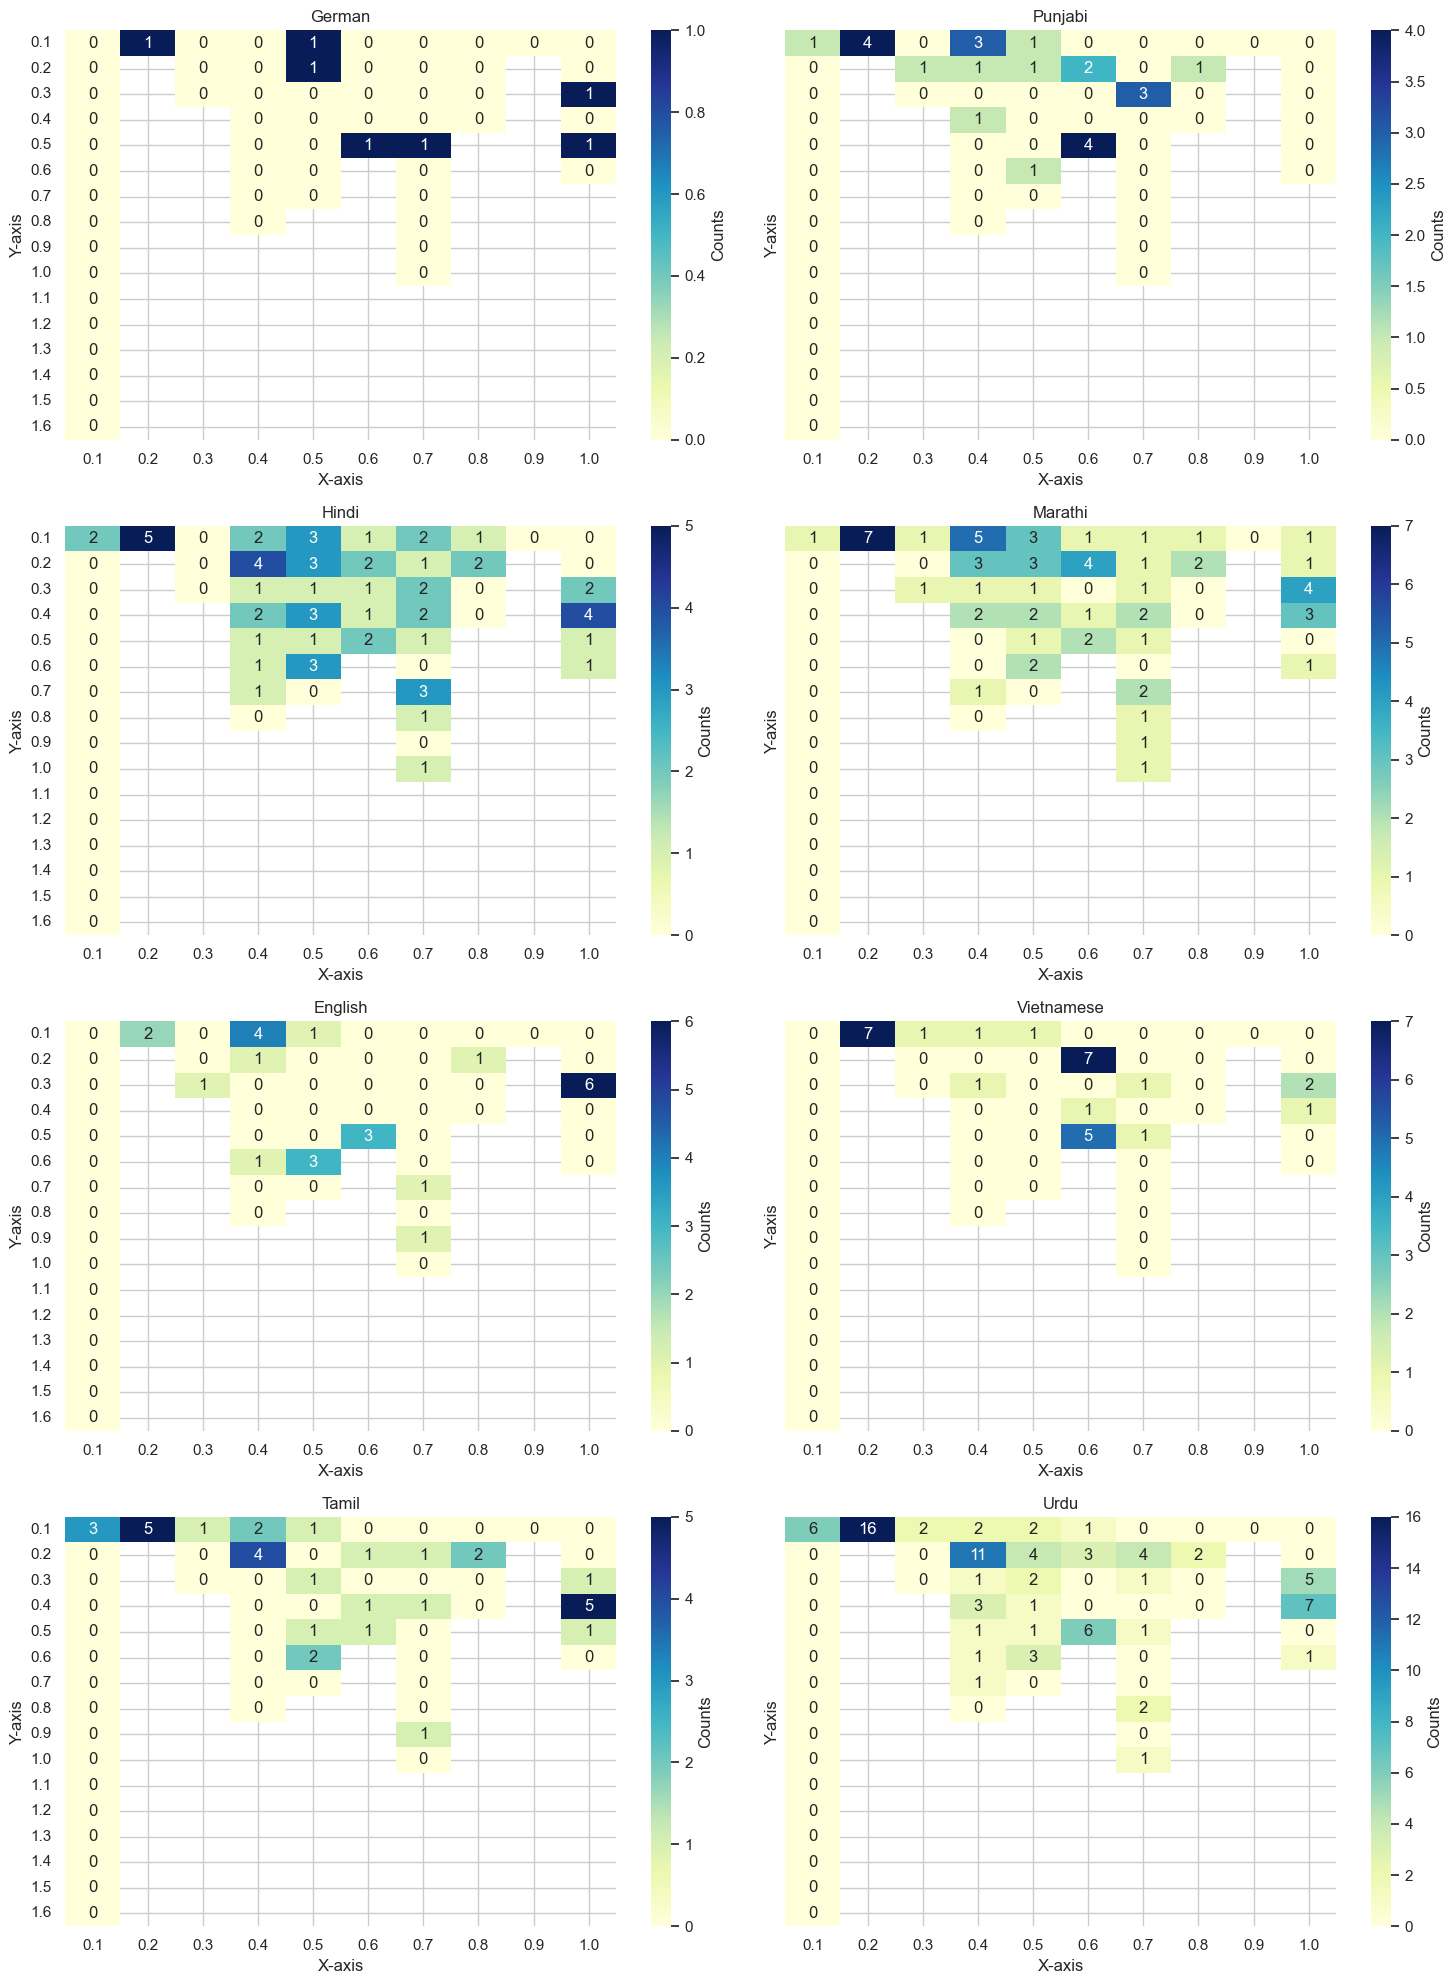

In [264]:
# Load the CSV file
file_to_analyze = 'data/07_WER_merged.csv'
df_full = pd.read_csv(file_to_analyze, delimiter=',', encoding='utf-8-sig')
df = df_full[df_full['Library'] == 'Assembly.AI']

# German vowel space mapping (SAMPA)
phenome_space = {
'p': (1, 0.1),
'b': (1, 0.2),
't': (1, 0.3),
'd': (1, 0.4),
'k': (1, 0.5),
'g': (1, 0.6),
'?': (0.9, 0.1),
'pf': (0.8, 0.1),
'ts': (0.8, 0.2),
'tS': (0.8, 0.3),
'dZ': (0.8, 0.4),
'f': (0.7, 0.1),
'v': (0.7, 0.2),
's': (0.7, 0.3),
'z': (0.7, 0.4),
'S': (0.7, 0.5),
'Z': (0.7, 0.6),
'C': (0.7, 0.7),
'j': (0.7, 0.8),
'x': (0.7, 0.9),
'h': (0.7, 1),
'm': (0.6, 0.1),
'n': (0.6, 0.2),
'N': (0.6, 0.3),
'l': (0.6, 0.4),
'R': (0.6, 0.5),
'I': (0.5, 0.1),
'E': (0.5, 0.2),
'a': (0.5, 0.3),
'O': (0.5, 0.4),
'U': (0.5, 0.5),
'Y': (0.5, 0.6),
'9': (0.5, 0.7),
'i:': (0.4, 0.1),
'e:': (0.4, 0.2),
'E:': (0.4, 0.3),
'a:': (0.4, 0.4),
'o:': (0.4, 0.5),
'u:': (0.4, 0.6),
'y:': (0.4, 0.7),
'2:': (0.4, 0.8),
'aI': (0.3, 0.1),
'aU': (0.3, 0.2),
'OY': (0.3, 0.3),
'@': (0.2, 0.1),
'6': (0.1, 0.1),
'i:6': (0.1, 0.2),
'I6': (0.1, 0.3),
'y:6': (0.1, 0.4),
'Y6': (0.1, 0.5),
'e:6': (0.1, 0.6),
'E6': (0.1, 0.7),
'E:6': (0.1, 0.8),
'2:6': (0.1, 0.9),
'96': (0.1, 1),
'a:6': (0.1, 1.1),
'a6': (0.1, 1.2),
'u:6': (0.1, 1.3),
'U6': (0.1, 1.4),
'o:6': (0.1, 1.5),
'O6': (0.1, 1.6)
}


# Prepare the data
heatmap_data = prepare_data(df)

# Determine how many rows and columns to use in the subplots based on the number of languages
num_languages = len(heatmap_data)
ncols = 2  # Adjust the number of columns you want
nrows = (num_languages + ncols - 1) // ncols  # Calculate number of rows needed

# Create the figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), sharey=True)

# Flatten the axes array if it's 2D (i.e., more than 1 row)
axes = axes.ravel()  # Convert the 2D array to 1D for easier iteration


# Plot each heatmap
for ax, (nativeLang, matrix) in zip(axes, heatmap_data):
    sns.heatmap(matrix, ax=ax, cmap='YlGnBu', annot=True, fmt='g', cbar_kws={'label': 'Counts'})
    ax.set_title(nativeLang)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')


# If there are fewer subplots than axes, remove unused axes
for ax in axes[len(heatmap_data):]:
    ax.remove()

plt.tight_layout()
plt.show()


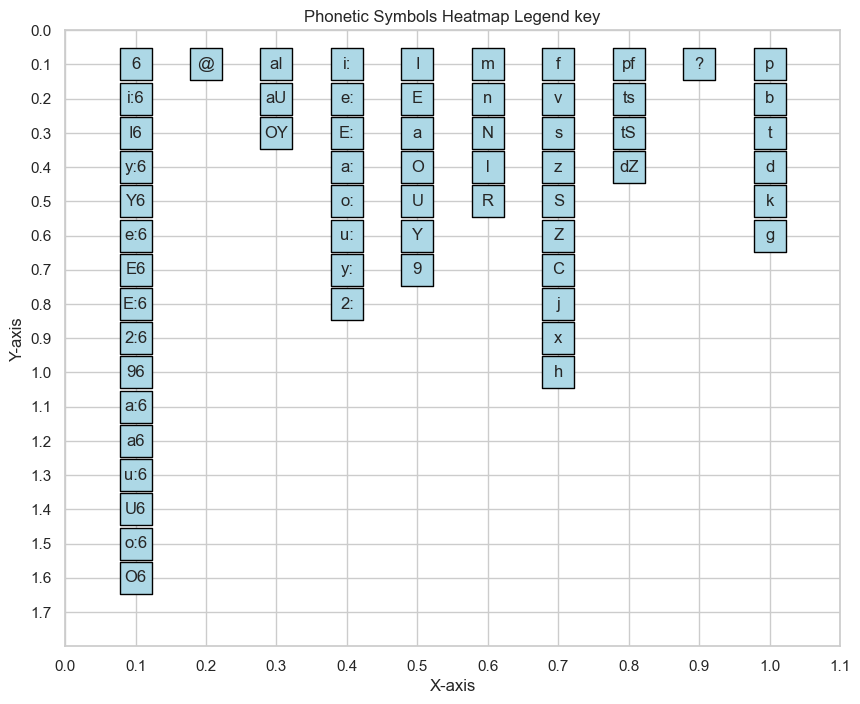

In [286]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    'Symbol': ['p', 'b', 't', 'd', 'k', 'g', '?', 'pf', 'ts', 'tS', 'dZ', 'f', 'v', 's', 'z', 'S', 'Z', 'C', 'j', 'x', 'h', 
               'm', 'n', 'N', 'l', 'R', 'I', 'E', 'a', 'O', 'U', 'Y', '9', 'i:', 'e:', 'E:', 'a:', 'o:', 'u:', 'y:', '2:',
               'aI', 'aU', 'OY', '@', '6', 'i:6', 'I6', 'y:6', 'Y6', 'e:6', 'E6', 'E:6', '2:6', '96', 'a:6', 'a6', 'u:6', 
               'U6', 'o:6', 'O6'],
    'X': [1,
1,
1,
1,
1,
1,
0.9,
0.8,
0.8,
0.8,
0.8,
0.7,
0.7,
0.7,
0.7,
0.7,
0.7,
0.7,
0.7,
0.7,
0.7,
0.6,
0.6,
0.6,
0.6,
0.6,
0.5,
0.5,
0.5,
0.5,
0.5,
0.5,
0.5,
0.4,
0.4,
0.4,
0.4,
0.4,
0.4,
0.4,
0.4,
0.3,
0.3,
0.3,
0.2,
0.1,
0.1,
0.1,
0.1,
0.1,
0.1,
0.1,
0.1,
0.1,
0.1,
0.1,
0.1,
0.1,
0.1,
0.1,
0.1],
    'Y': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.1, 0.1, 0.2, 0.3, 0.4, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,
          0.1, 0.2, 0.3, 0.4, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 
          0.1, 0.2, 0.3, 0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Set up the plot
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(df['X'], df['Y'], marker='s', s=500, c='lightblue', edgecolors='black')

# Annotate each symbol at its (X, Y) coordinate
for i in range(len(df)):
    plt.text(df['X'][i], df['Y'][i], df['Symbol'][i], ha='center', va='center', fontsize=12)

# Modify axes limits
#plt.xlim([0, 1.1])  # Set x-axis limits
plt.ylim([1.8, 0])  # Set y-axis limits


plt.yticks([i/10 for i in range(0, 18)])  # 0.0 to 1.7 with 0.1 increments

plt.xticks([i/10 for i in range(0, 12)])  # 0.0 to 1.1 with 0.1 increments


# Optionally, invert one or both axes
# plt.gca().invert_yaxis()  # Uncomment if needed to invert y-axis
# plt.gca().invert_xaxis()  # Uncomment if needed to invert x-axis

# Labels and title
plt.title('Phonetic Symbols Heatmap Legend key')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show plot
plt.show()


### Additional Analysis of Phonemes(Categories) for WER

In [294]:
#Analysis of Phonemes for different categories(for future) 
vowel_realisation_r = ['6','i:6','I6','y:6','Y6','e:6','E6','E:6','2:6','96','a:6','a6','u:6','U6','o:6','O6']
free_diphthongs = ['aI', 'aU' ,'OY']
glottal_stop = ['?']
phonemic_affricates = ['pf','ts','tS','dZ']
checked_vowels = ['I', 'E', 'a', 'O', 'U', 'Y', '9:']
plosives =  ['p', 'b', 't', 'd', 'k', 'g']
fricatives= ['f','v','s','z','S','Z','C','j','x','h']
nasals_liquids = ['m','n', 'N','l', 'R']
vowels = ['i:', 'e:', 'E:', 'a:', 'o:', 'u:', 'y:', '2:'] 
schwa = ['@']

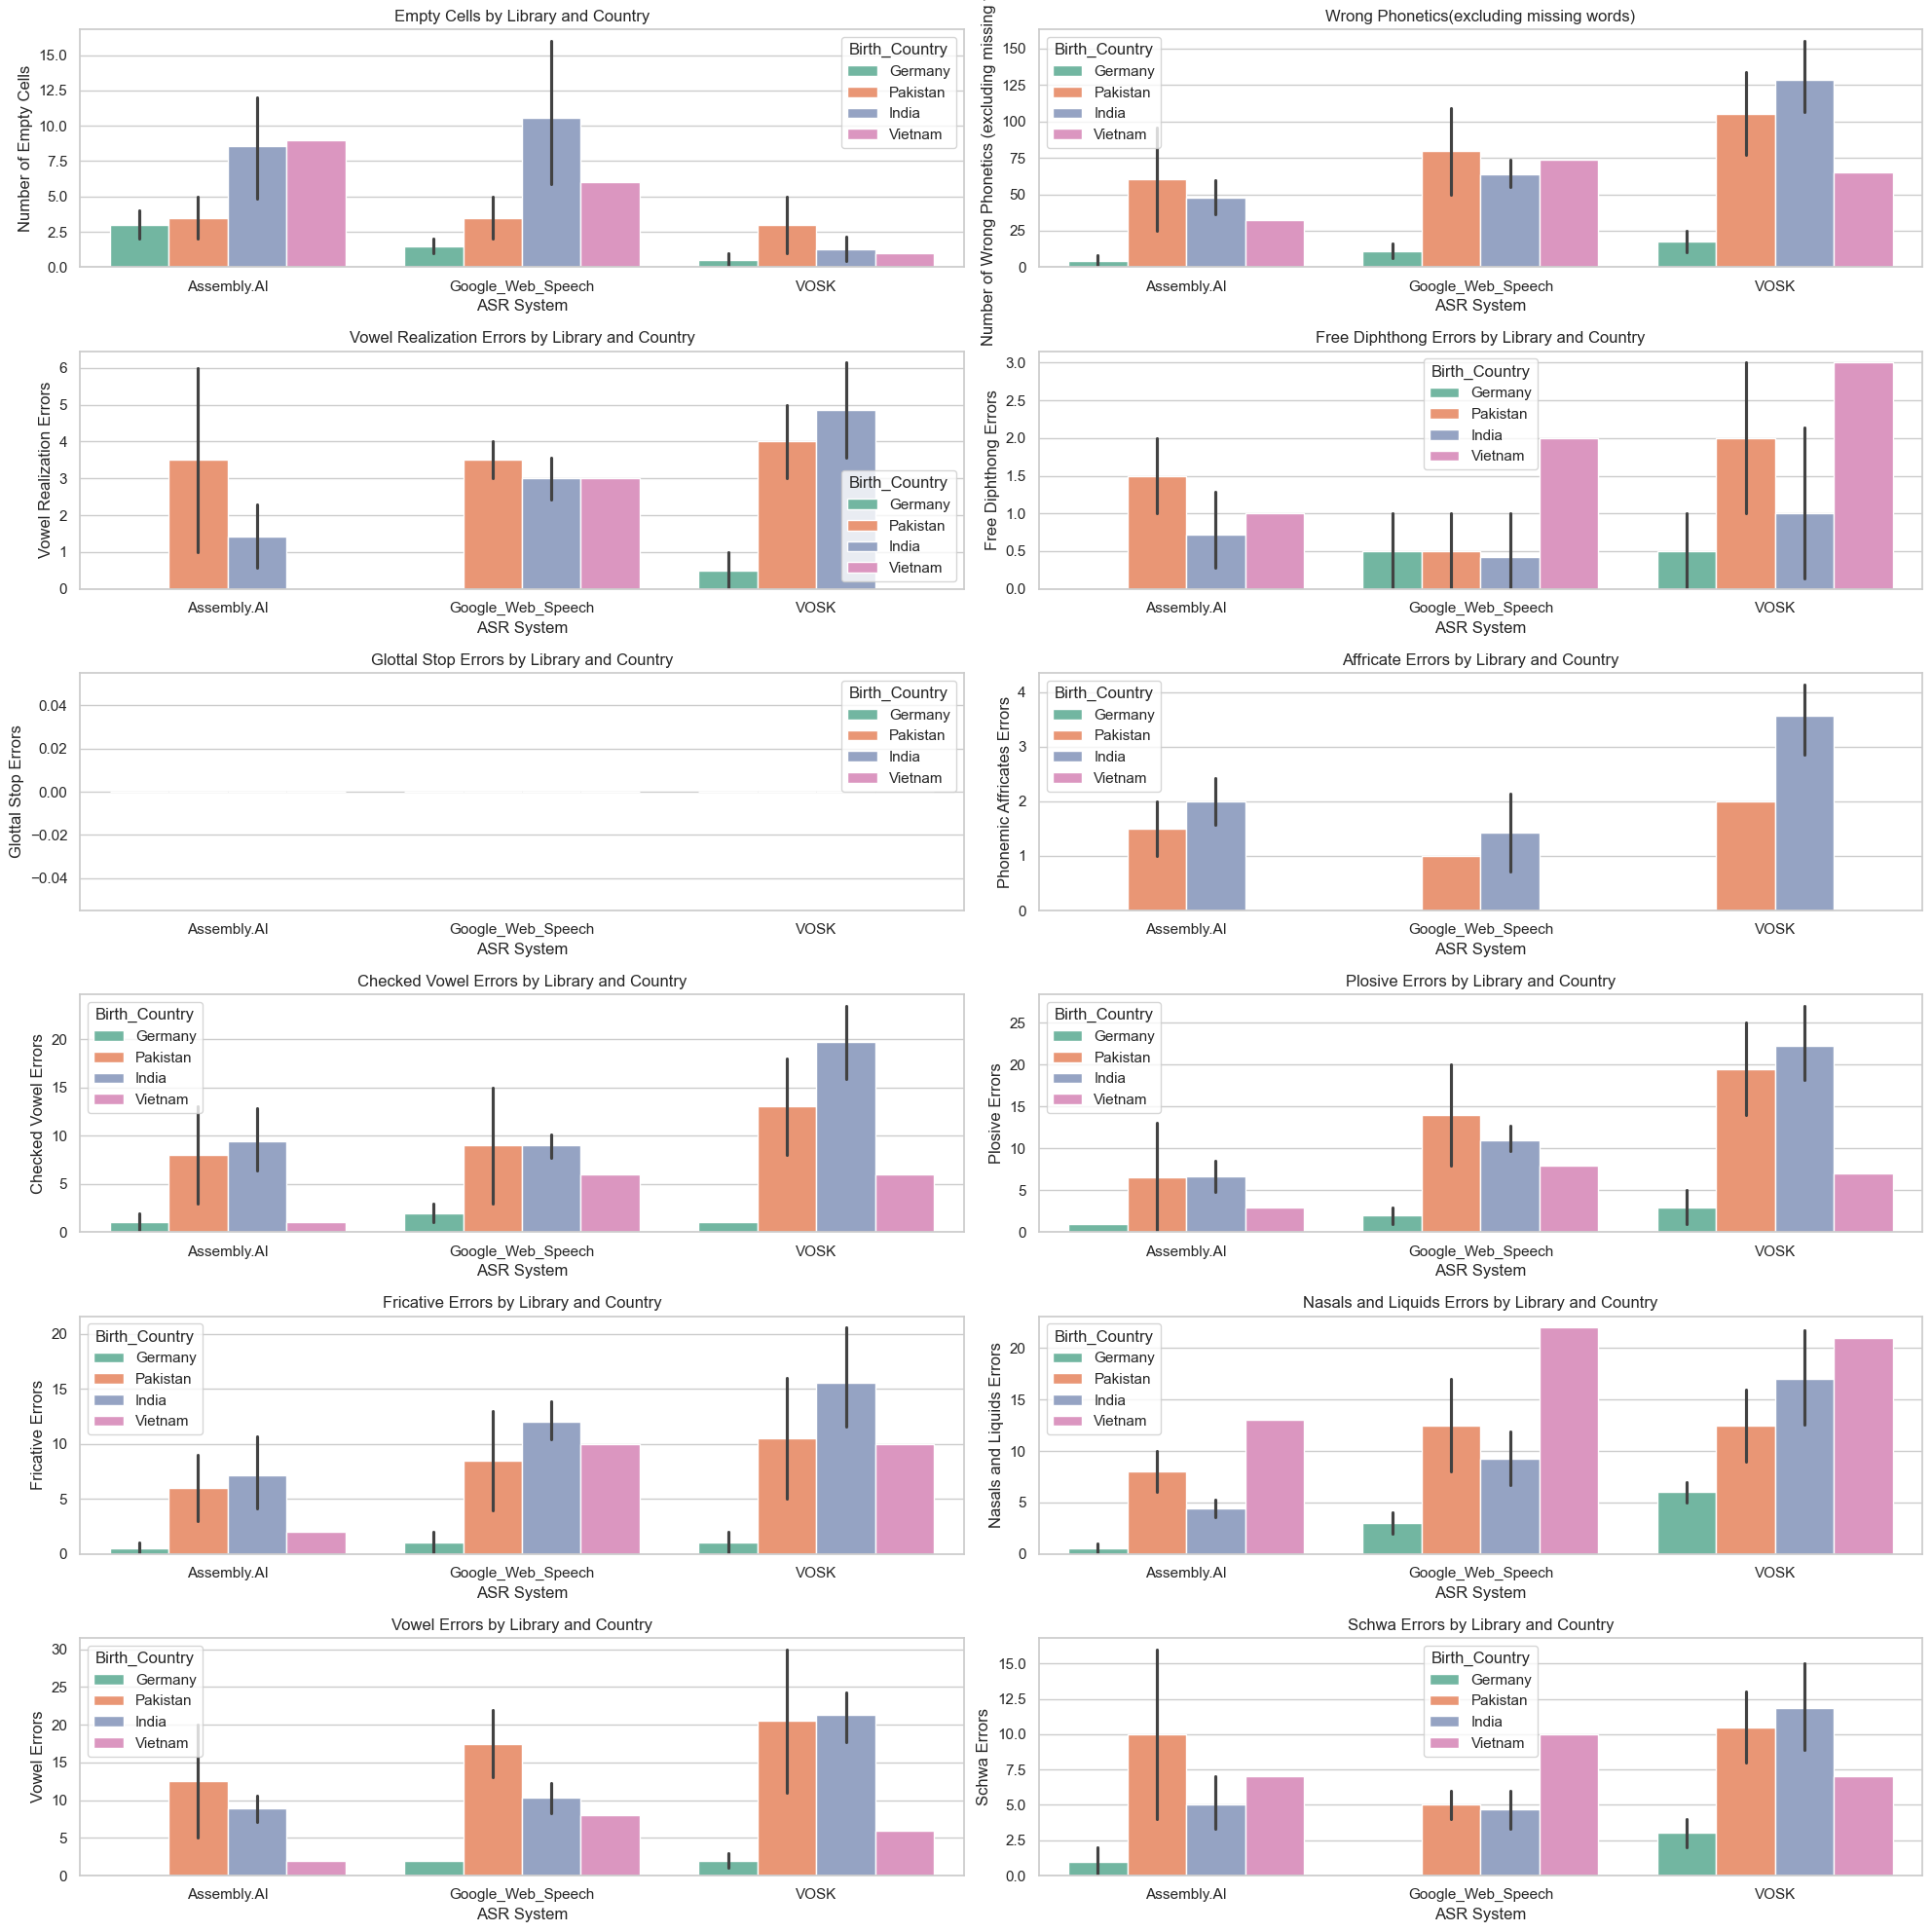

In [302]:
# Load the CSV file
file_to_analyze = 'data/07_WER_merged.csv'
df = pd.read_csv(file_to_analyze, delimiter=',', encoding='utf-8-sig')

# List of metrics to plot
metrics = [
    'empty_cells',
    'wrong_p_sum',
    'wrong_count_vowel_realisation_r',
    'wrong_count_free_diphthongs',
    'wrong_count_glottal_stop',
    'wrong_count_phonemic_affricates',
    'wrong_count_checked_vowels',
    'wrong_count_plosives',
    'wrong_count_fricatives',
    'wrong_count_nasals_liquids',
    'wrong_count_vowels',
    'wrong_count_schwa',
]

# Custom titles for each subplot
titles = [
    'Empty Cells by Library and Country',
    'Wrong Phonetics(excluding missing words)',
    'Vowel Realization Errors by Library and Country',
    'Free Diphthong Errors by Library and Country',
    'Glottal Stop Errors by Library and Country',
    'Affricate Errors by Library and Country',
    'Checked Vowel Errors by Library and Country',
    'Plosive Errors by Library and Country',
    'Fricative Errors by Library and Country',
    'Nasals and Liquids Errors by Library and Country',
    'Vowel Errors by Library and Country',
    'Schwa Errors by Library and Country'
]

# Custom y-axis labels for each metric
y_labels = [
    'Number of Empty Cells',
    'Number of Wrong Phonetics (excluding missing words)',
    'Vowel Realization Errors',
    'Free Diphthong Errors',
    'Glottal Stop Errors',
    'Phonemic Affricates Errors',
    'Checked Vowel Errors',
    'Plosive Errors',
    'Fricative Errors',
    'Nasals and Liquids Errors',
    'Vowel Errors',
    'Schwa Errors'
]


# Create a figure with GridSpec to control width and height ratios
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(6, 2, width_ratios=[1, 1], height_ratios=[2, 2, 2, 2, 2,2])  # Adjust grid

# Adjustment of spacing
plt.subplots_adjust(wspace=0.2, hspace=1)  # wspace controls width space, hspace controls height space




# Loop through metrics and plot on subplots
for i, metric in enumerate(metrics):
    row = i // 2  # Determine row (integer division)
    col = i % 2   # Determine column (remainder)
    
    # Create a subplot for each metric
    ax = fig.add_subplot(gs[row, col])  
    
    # Use a barplot with color differentiation by 'BCountry'
    sns.barplot(data=df, x='Library', y=metric, hue='Birth_Country', ax=ax, palette='Set2')
    
    # Add titles and labels from the arrays
    ax.set_title(titles[i])  # Set the custom title
    ax.set_xlabel('ASR System')  # Set x-axis label (same for all)
    ax.set_ylabel(y_labels[i])  # Set custom y-axis label
    
    # Rotate x-axis labels for better readability
    #ax.tick_params(axis='x', rotation=90)

    # Add a legend if it's the first plot in the column
    if col == 0:
        ax.legend(title='Birth_Country')

# Tight layout for better space usage
plt.tight_layout()

# Display the plot
plt.show()


## Extra Charts

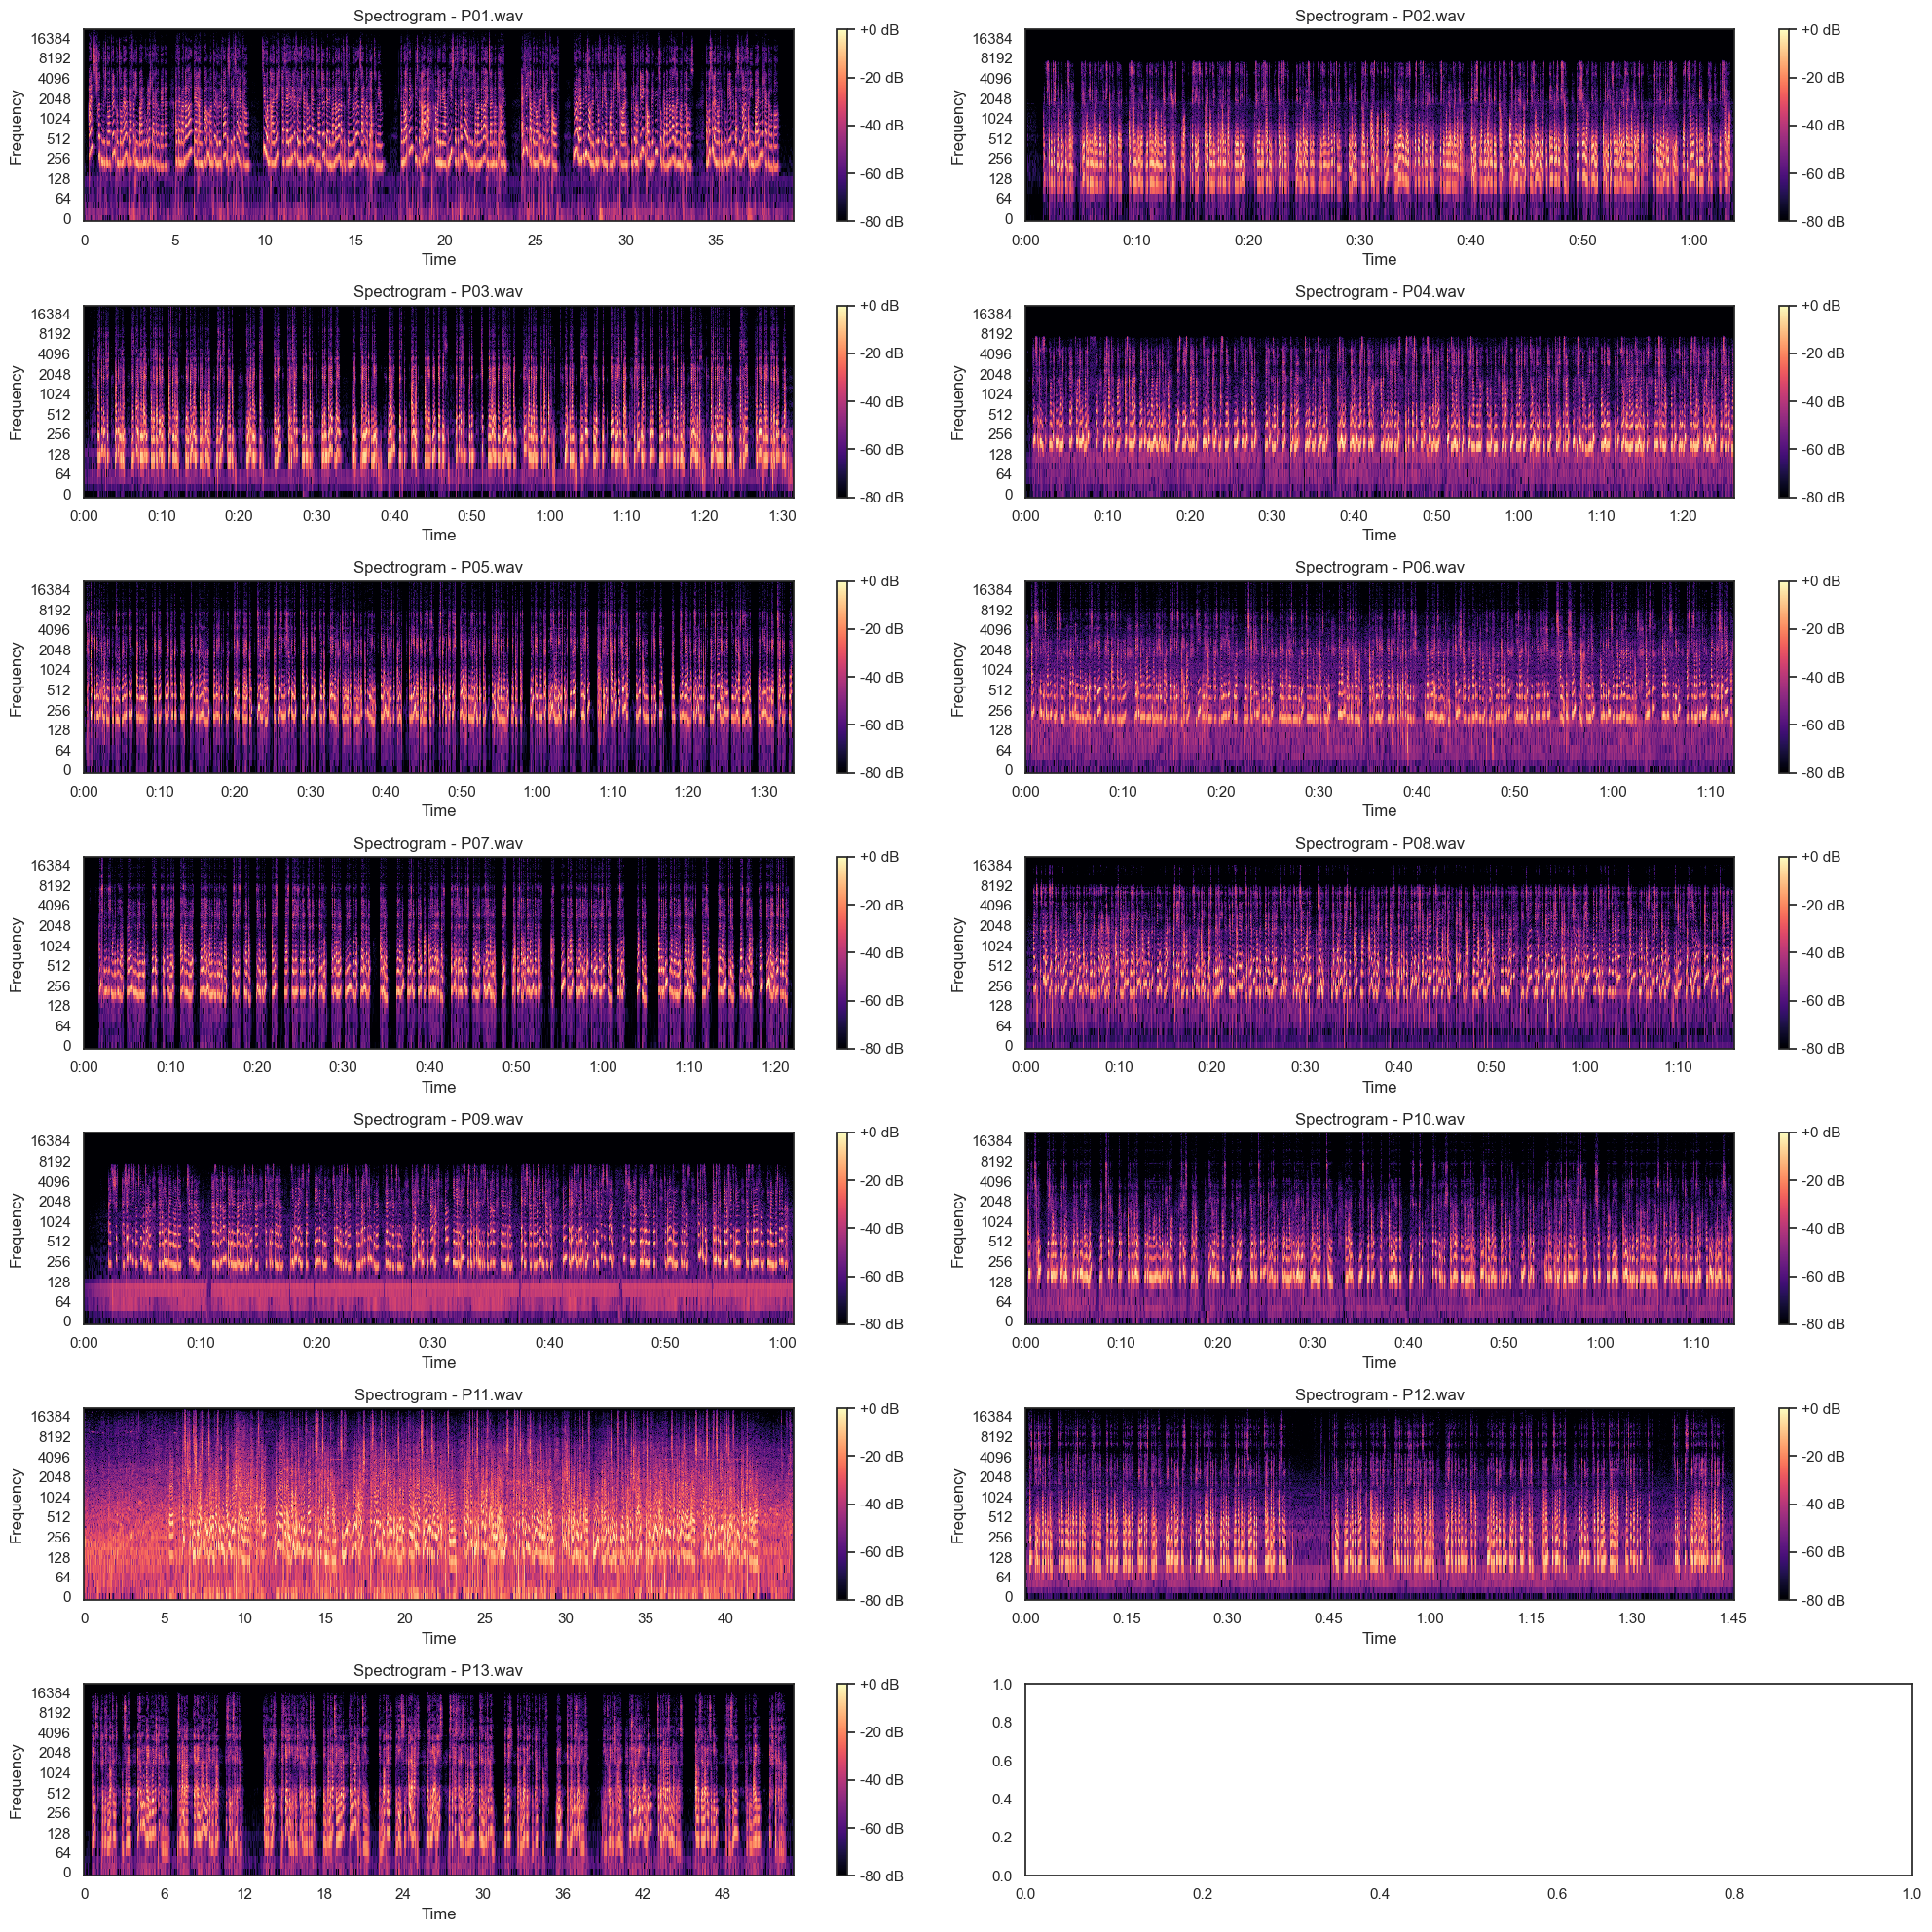

In [306]:
def load_audio(file_path):
    audio = AudioSegment.from_file(file_path)
    return audio

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

def plot_spectrogram(y, sr, ax, file_name):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax)
    ax.set_title(f'Spectrogram - {file_name}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    plt.colorbar(img, ax=ax, format='%+2.0f dB')

file_names = [
    '01.wav', '02.wav', '03.wav', '04.wav', '05.wav',
    '06.wav', '07.wav', '08.wav', '09.wav', '10.wav',
    '11.wav', '12.wav', '13.wav'
]
audio_dir = 'data/processed_audio'

# Set up a grid of subplots using seaborn
sns.set(style="white")
fig, axes = plt.subplots(7, 2, figsize=(20, 20))  # 3 rows, 4 columns grid

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the audio files and plot spectrograms in the subplots
for i, file_name in enumerate(file_names):
    file_path = os.path.join(audio_dir, file_name)
    if os.path.exists(file_path):
        y, sr = extract_features(file_path)
        plot_spectrogram(y, sr, axes[i], 'P' + file_name)
    else:
        print(f'File {file_path} does not exist.')

plt.tight_layout()
plt.show()


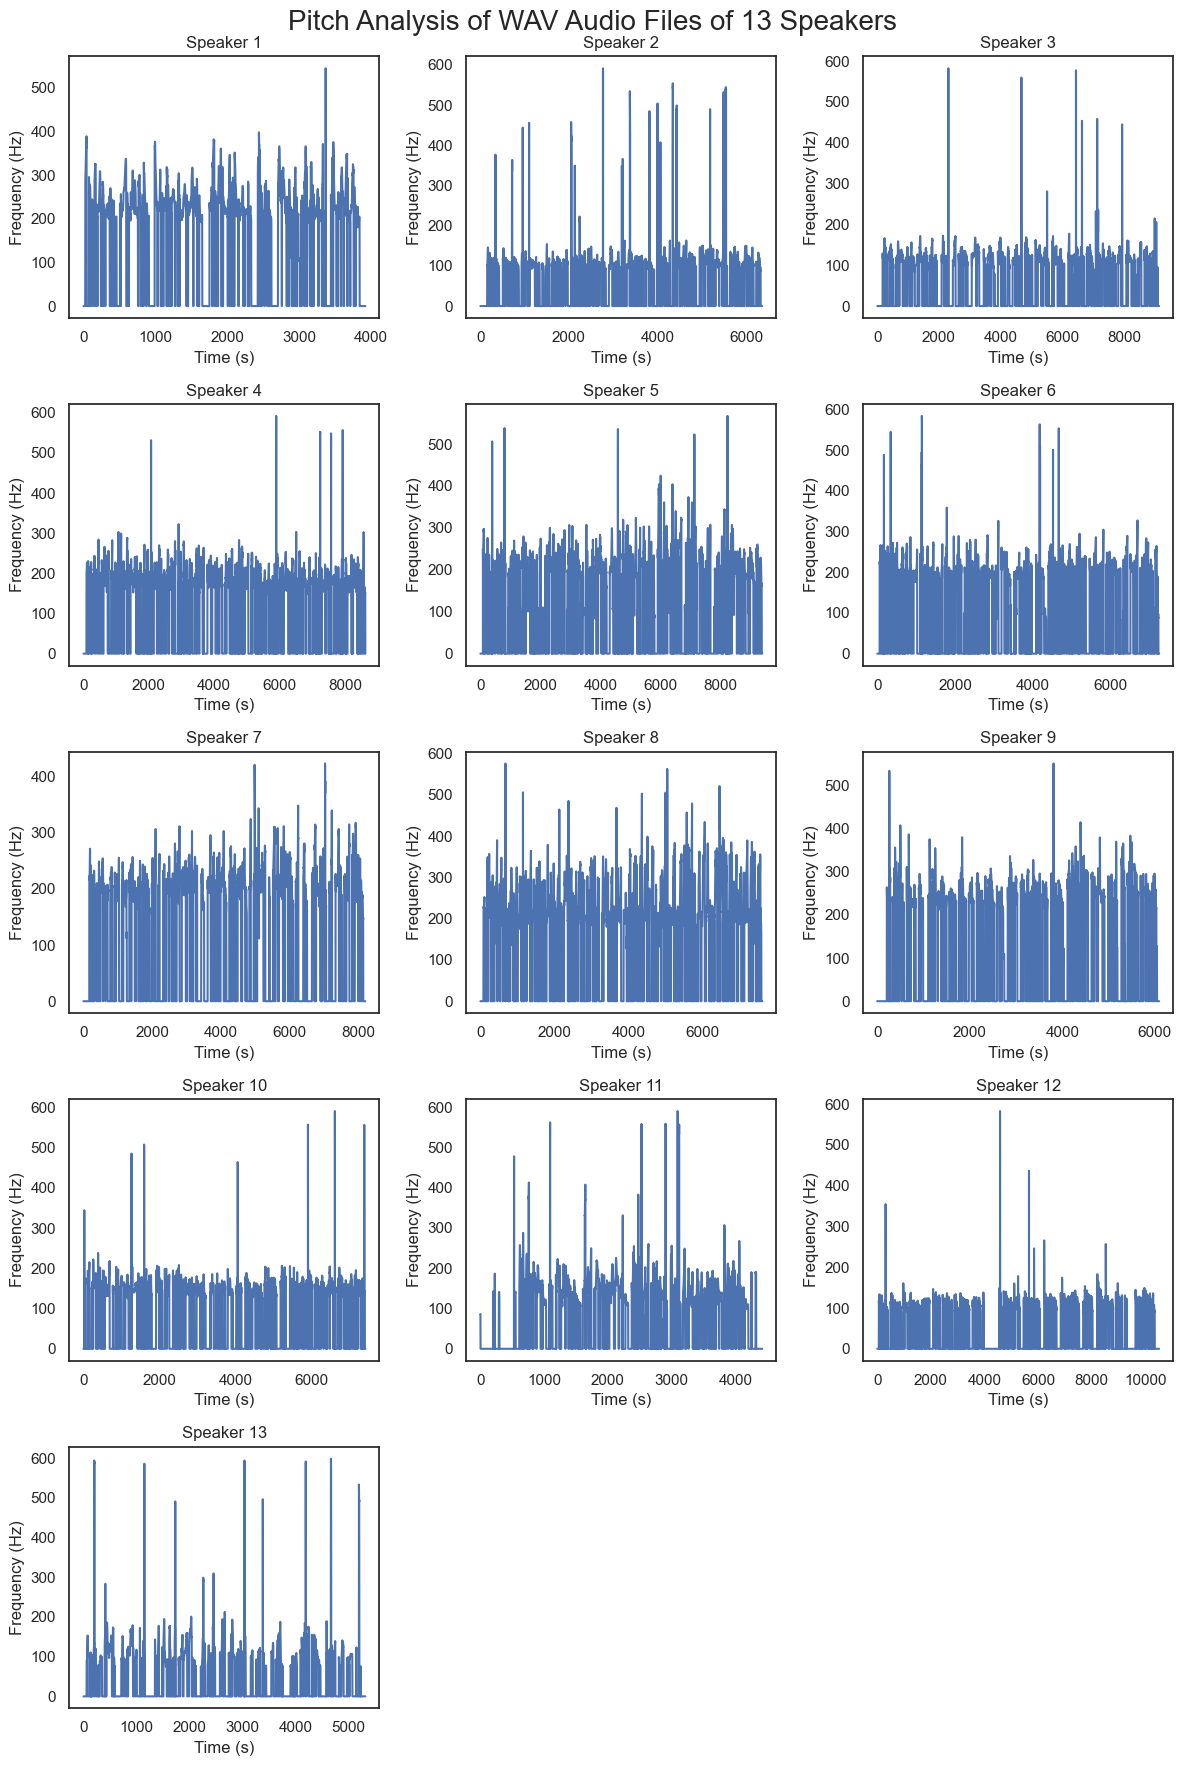

In [326]:


# Function to extract features (pitch, formants, intensity) from a sound
def extract_features(sound):
    pitch = sound.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    
    formants = sound.to_formant_burg()
    formant_values = [formants.get_value_at_time(i, formants.xmax) for i in range(1, 5)]  # First 4 formants
    
    intensity = sound.to_intensity()
    intensity_values = intensity.values
    
    return pitch_values, formant_values, intensity_values

# Function to plot the pitch of all 13 files in subplots
def plot_all_features(features):
    plt.figure(figsize=(12, 18))  # size based on number of subplots
    num_files = len(features)

    # Set a main title for the entire figure
    plt.suptitle('Pitch Analysis of WAV Audio Files of 13 Speakers', fontsize=20)

    # Create subplots in a 3x5 grid (can be adjusted if needed)
    for i in range(num_files):
        plt.subplot(5, 3, i+1)  # 3 rows, 5 columns, current index is i+1
        plt.plot(features[i]['pitch'])
        plt.title(f'Speaker {i+1}')  # Title as Sound 1, Sound 2, etc.
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
    
    plt.tight_layout()  #  layout to prevent overlap
    plt.show()

# File paths for all 13 audio files
file_paths = [f'data\\processed_audio\\{str(i).zfill(2)}.wav' for i in range(1, 14)]

# Analyze phonetics for all 13 files and extract features
sounds = []
features = []

for file in file_paths:
    sound = parselmouth.Sound(file)
    sounds.append(sound)
    pitch_values, formant_values, intensity_values = extract_features(sound)
    features.append({
        'pitch': pitch_values,
        'formants': formant_values,
        'intensity': intensity_values
    })

# Plot all pitch features in subplots
plot_all_features(features)
